In [1]:
! pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 6.3 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/8.1 MB 7.2 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 7.2 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 6.9 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------- ----------- 1.6/2.2 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.9 MB/s eta 0:00:00


Print 'q' to quit.


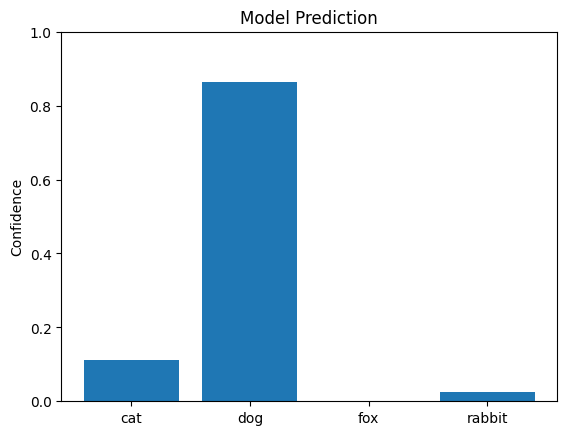

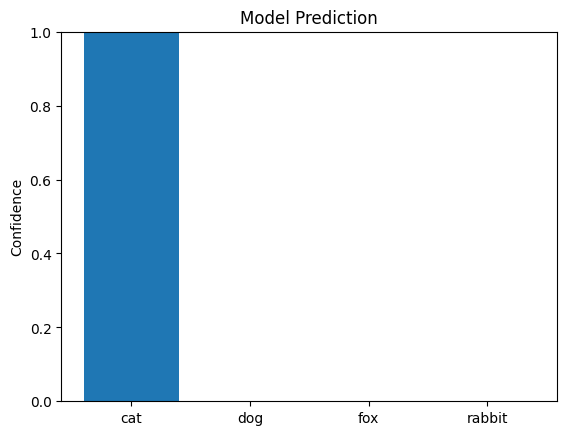

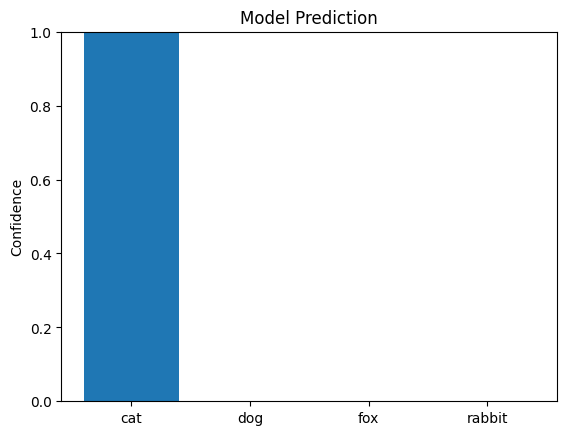

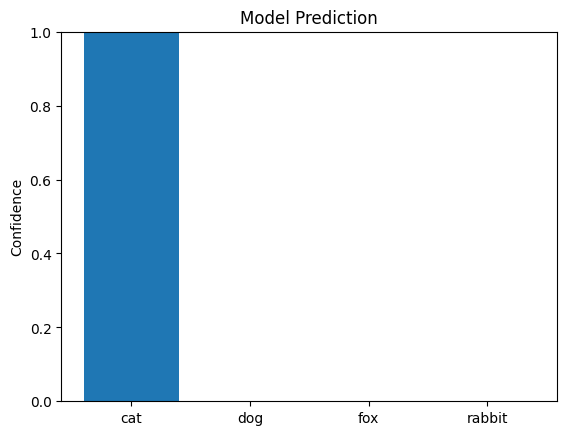

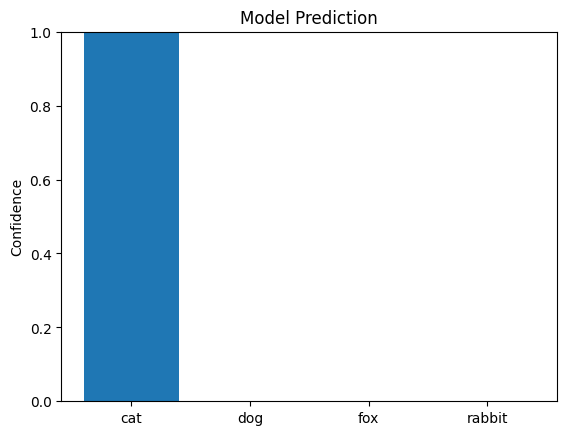

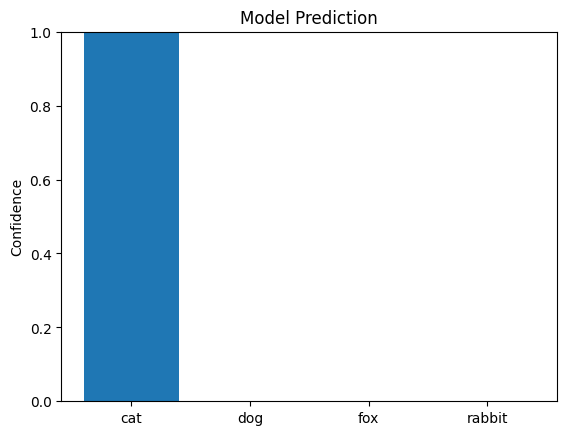

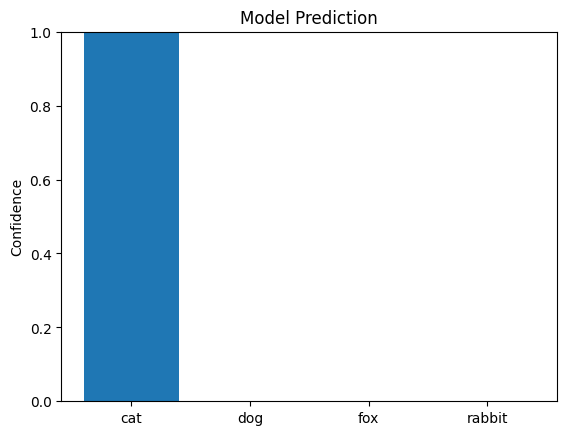

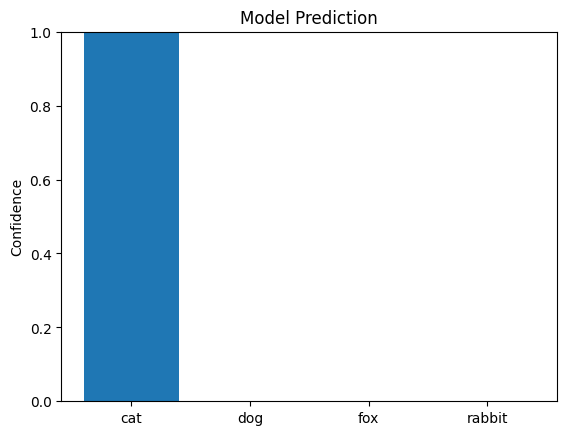

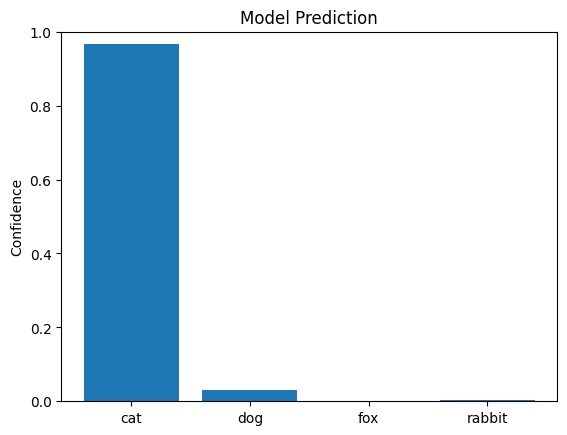

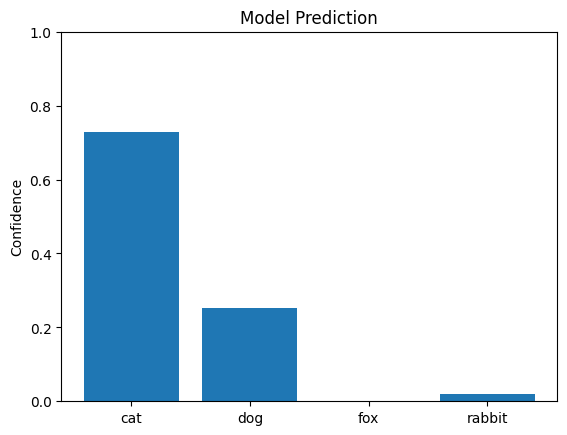

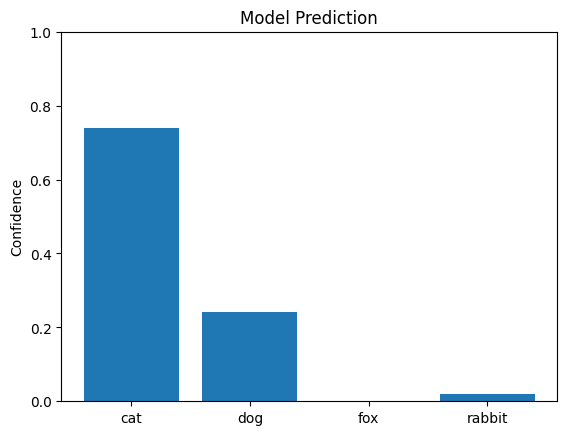

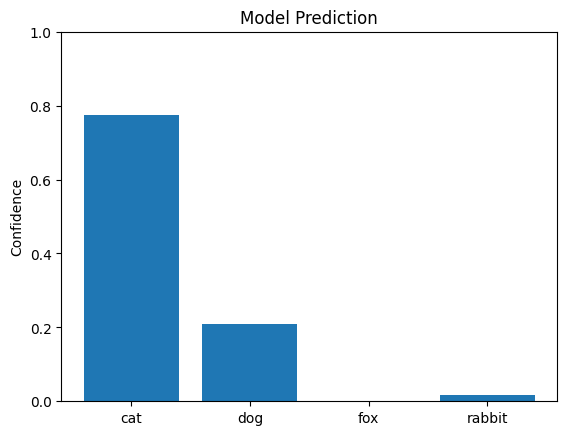

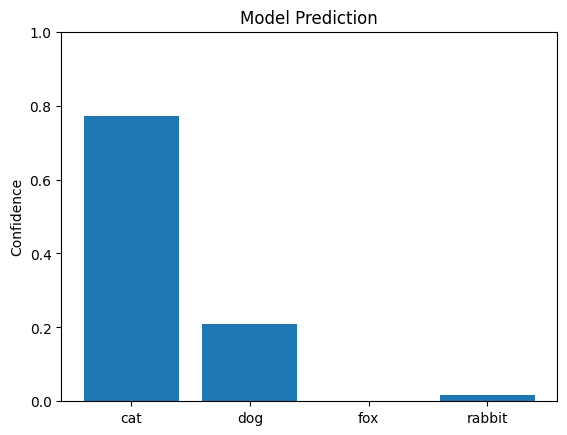

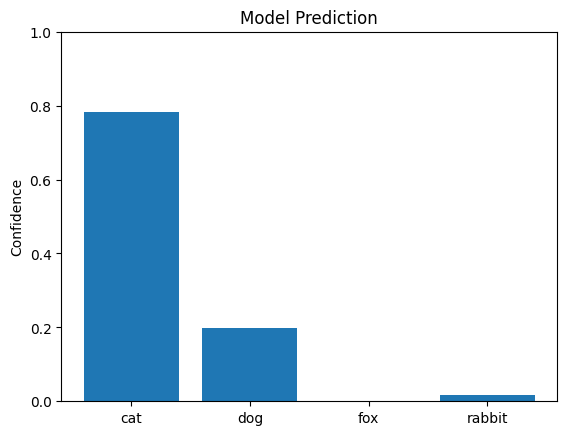

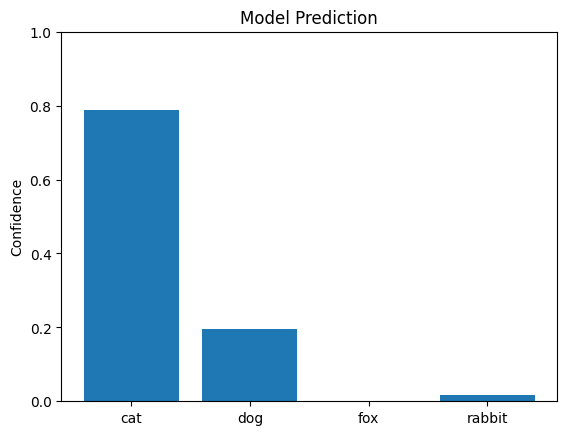

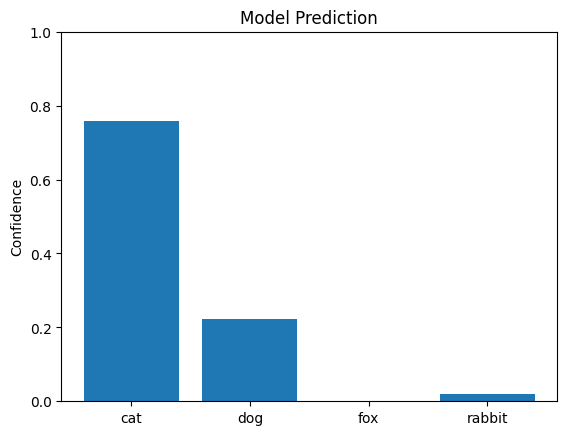

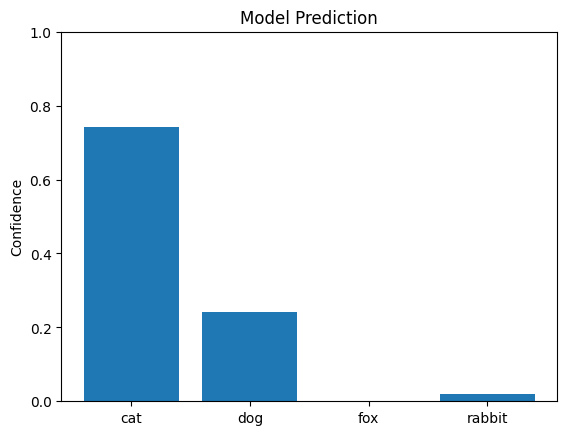

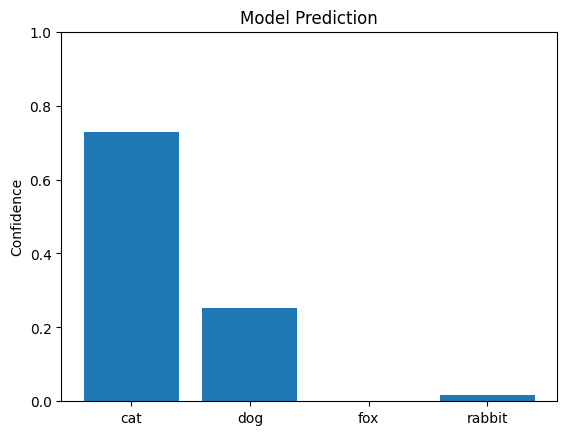

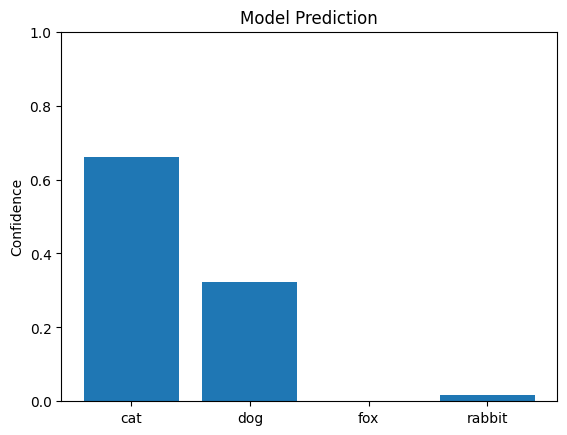

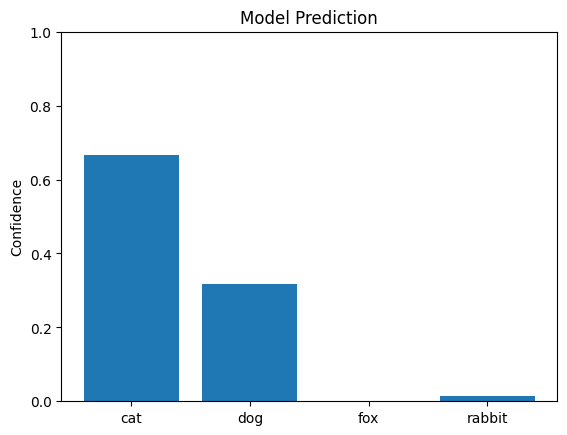

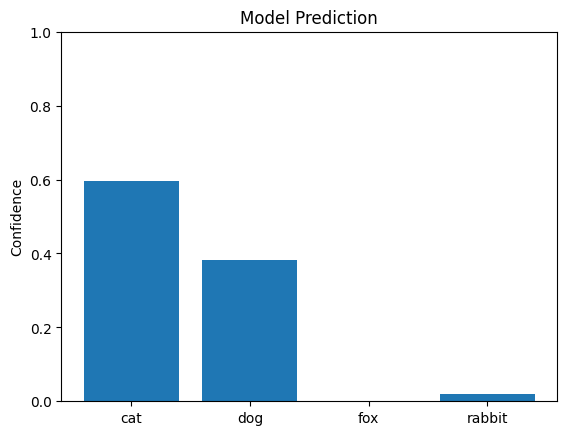

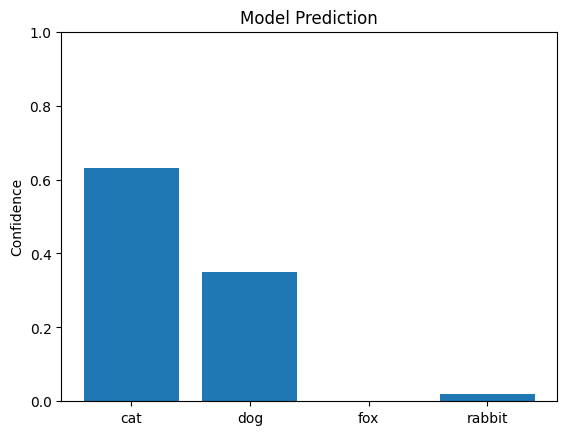

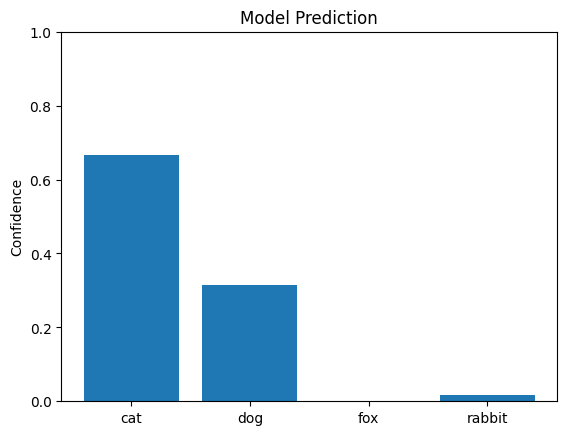

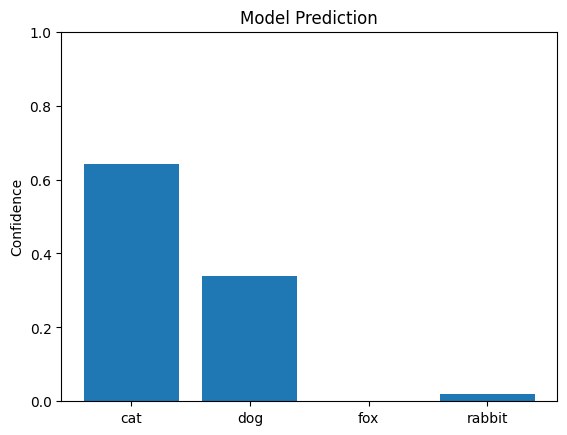

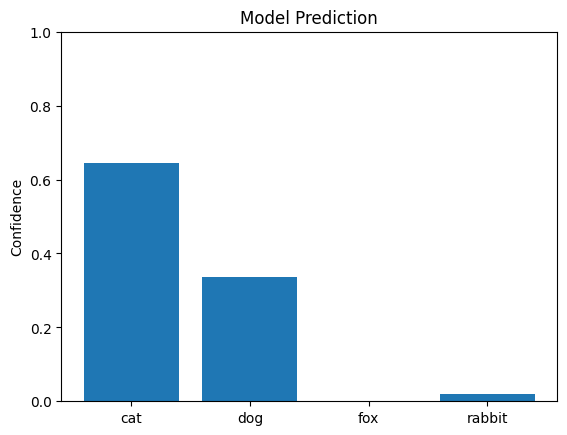

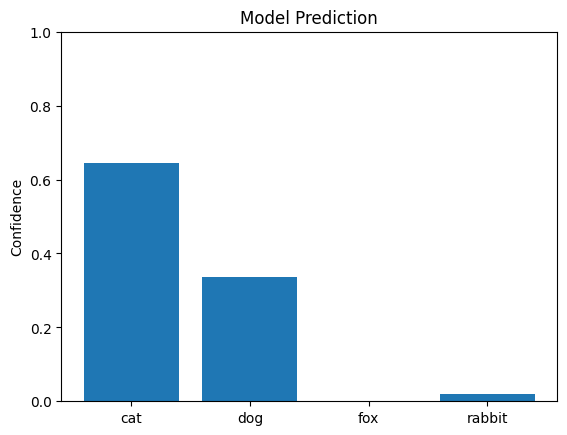

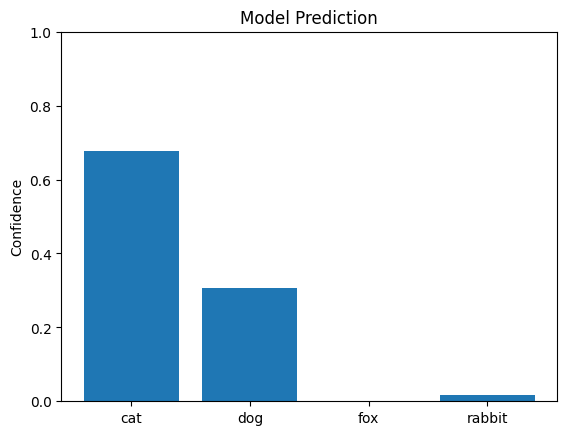

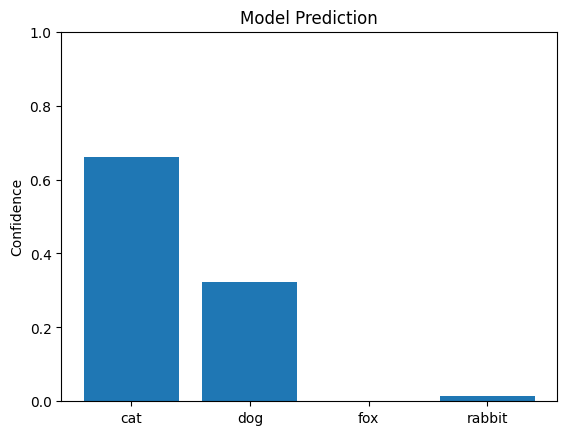

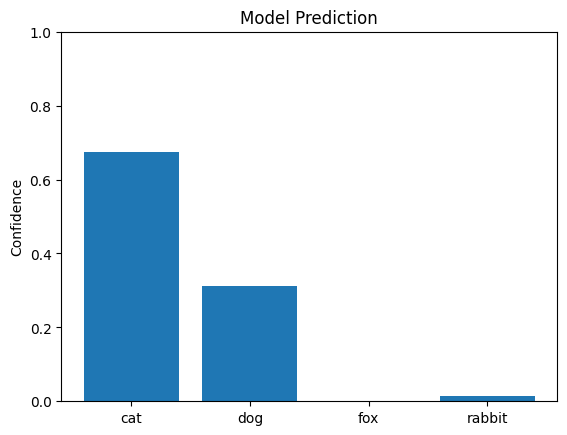

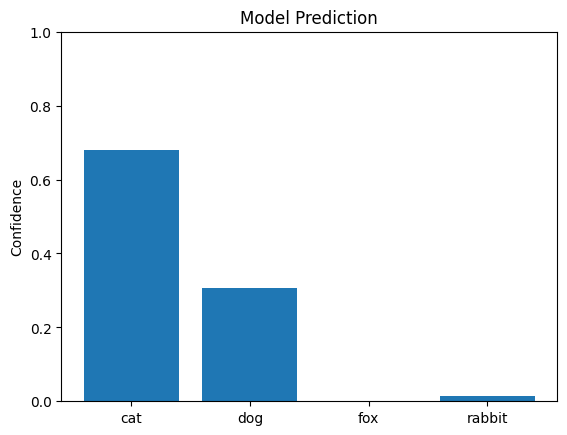

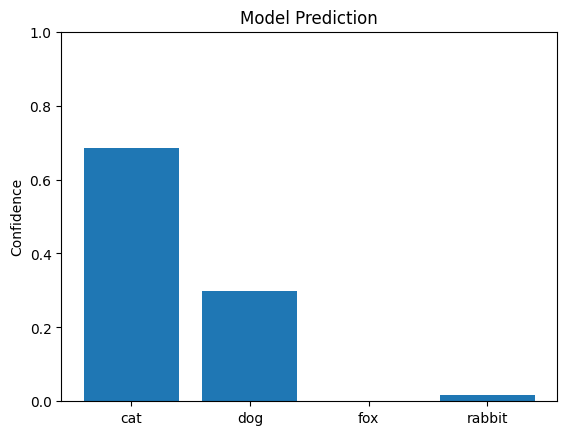

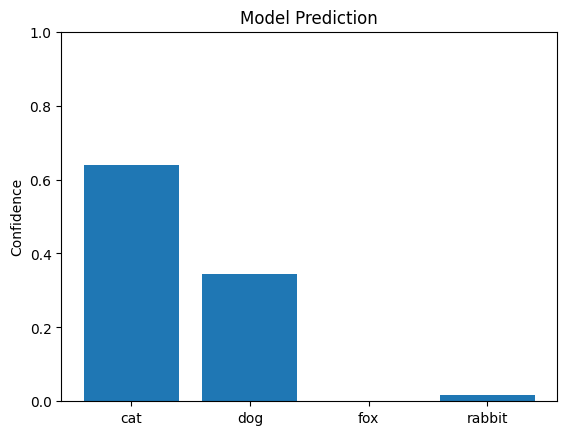

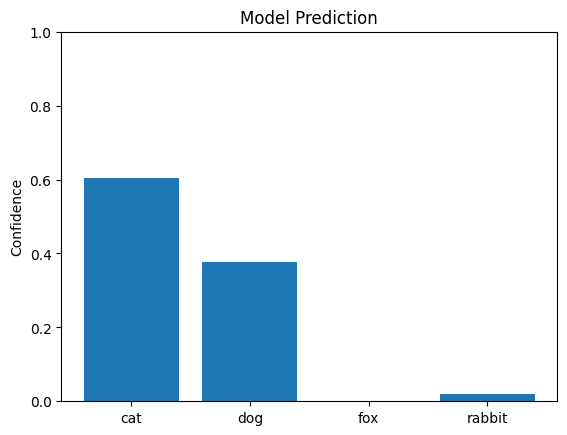

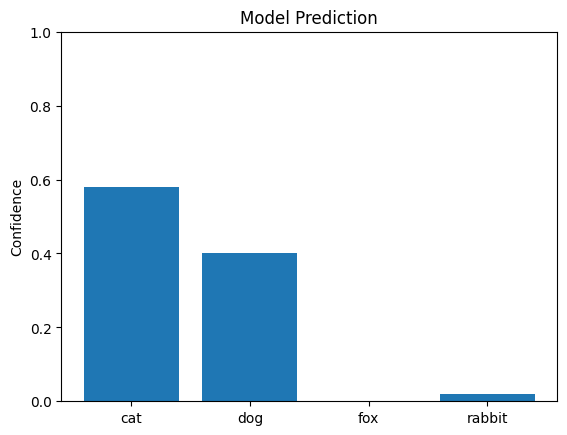

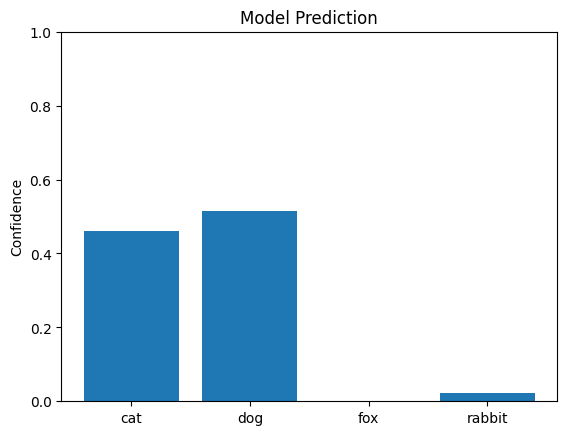

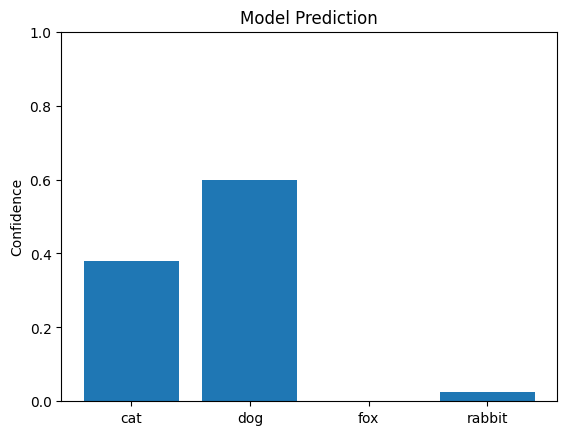

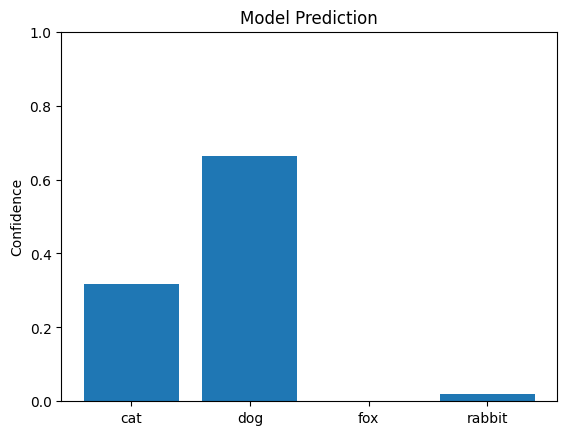

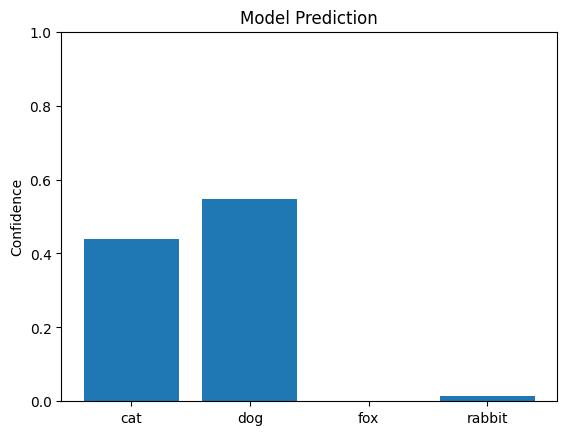

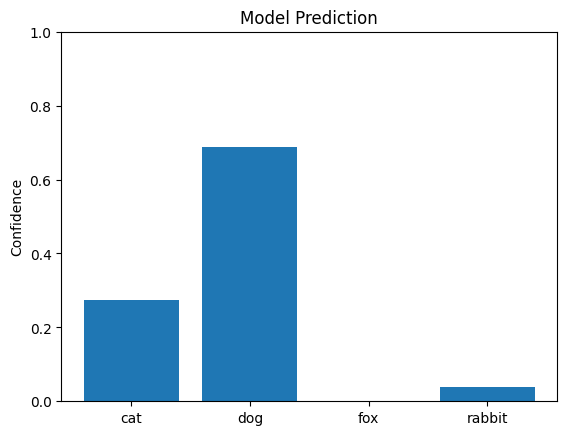

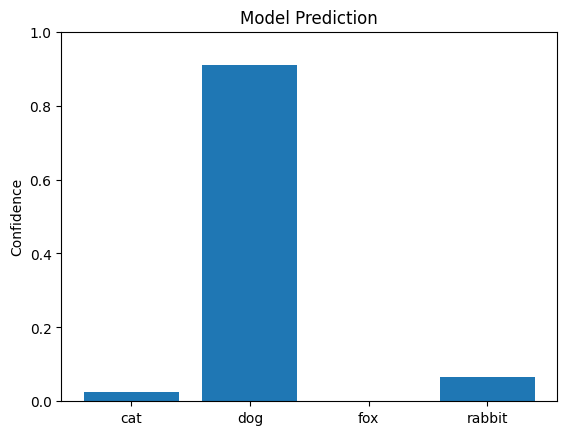

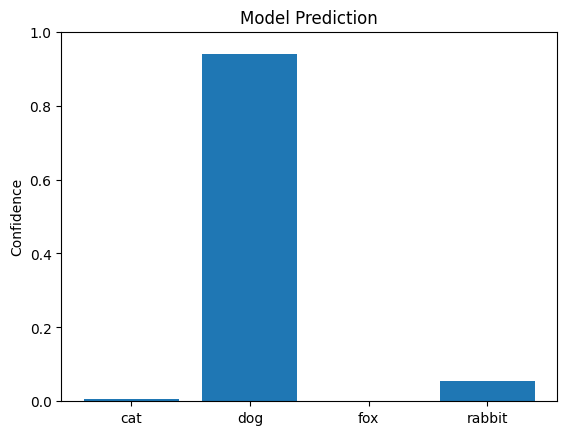

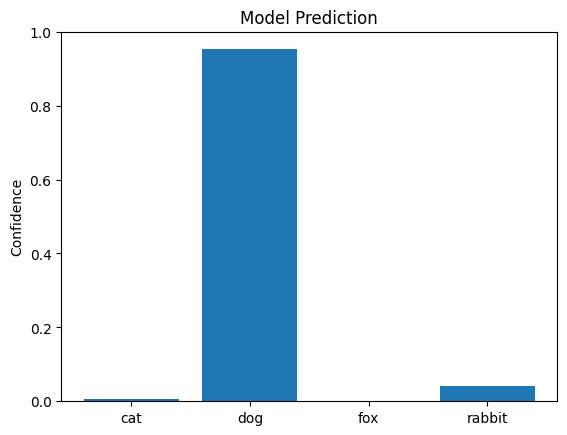

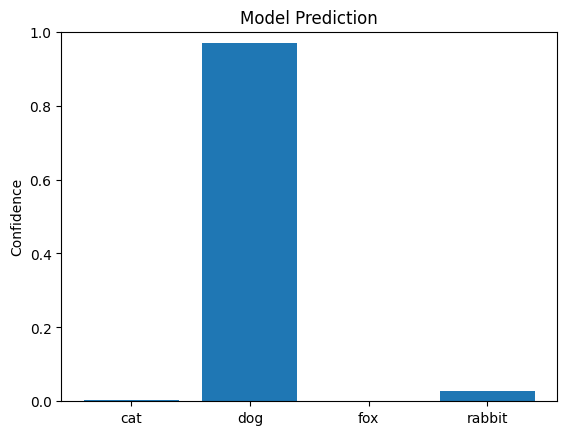

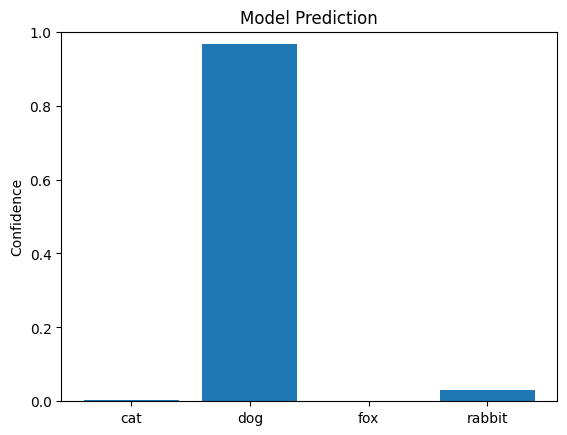

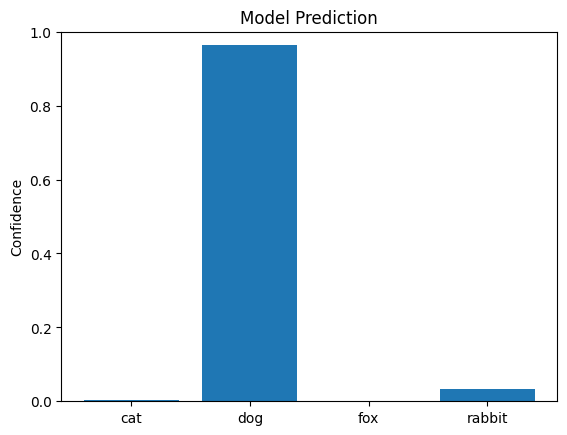

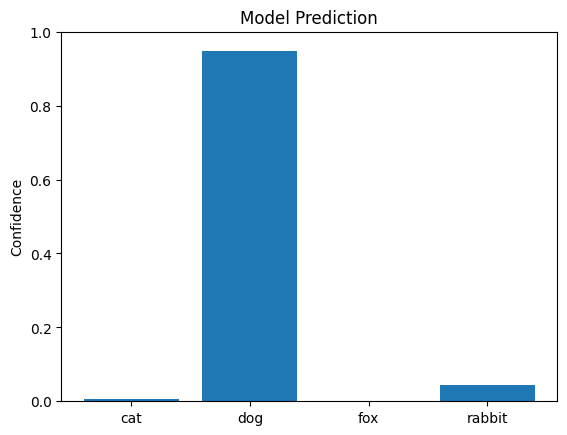

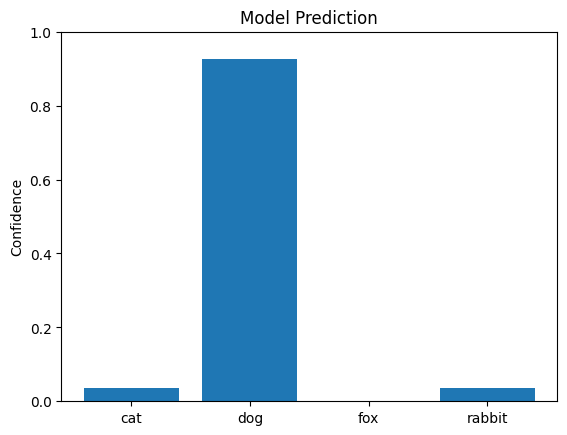

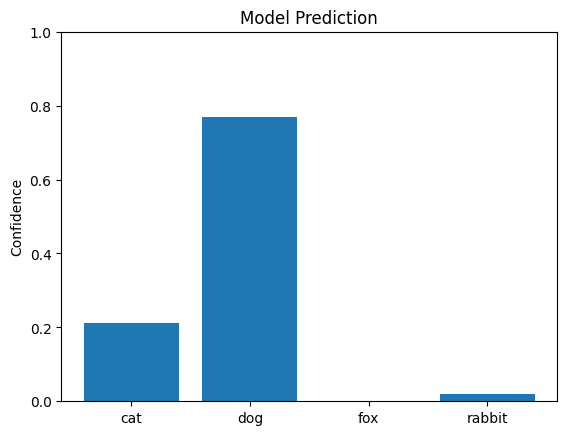

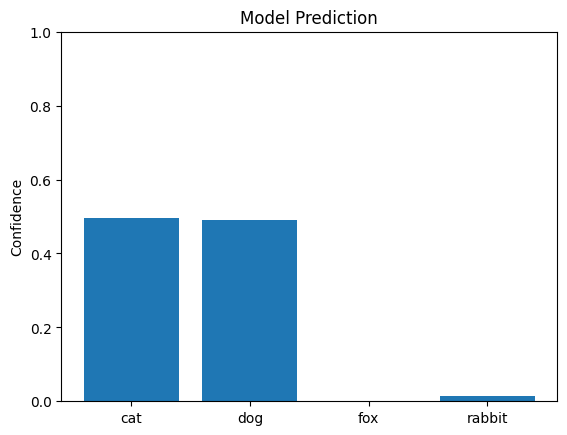

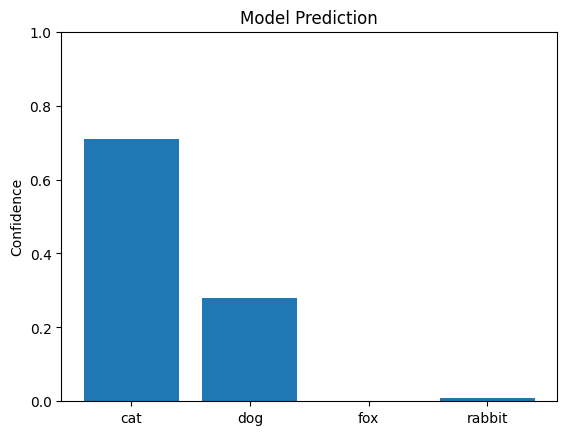

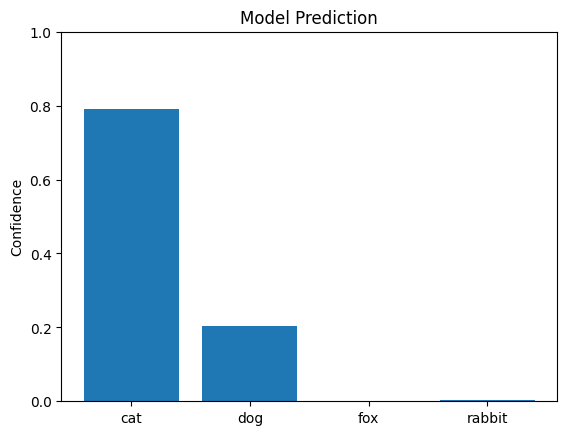

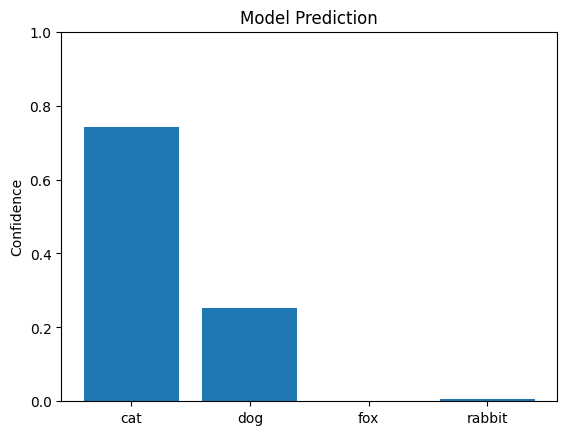

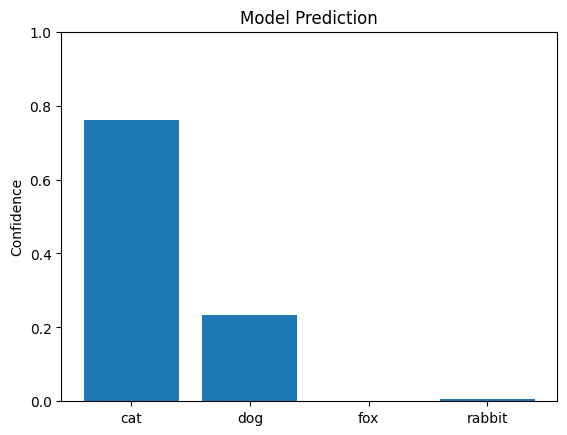

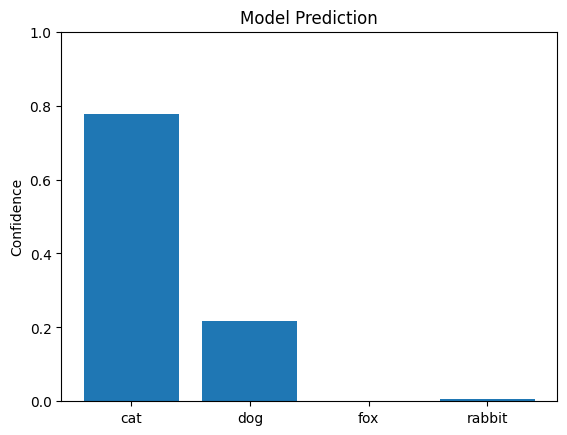

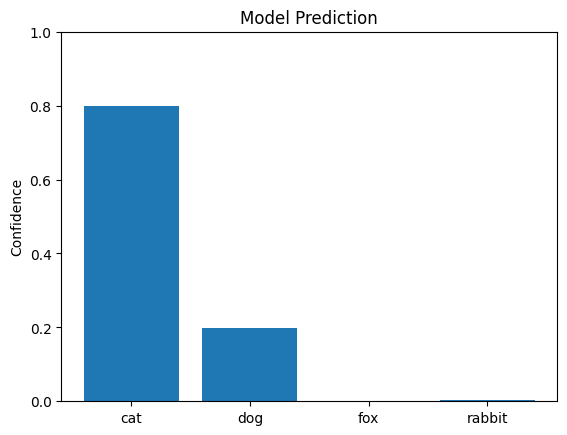

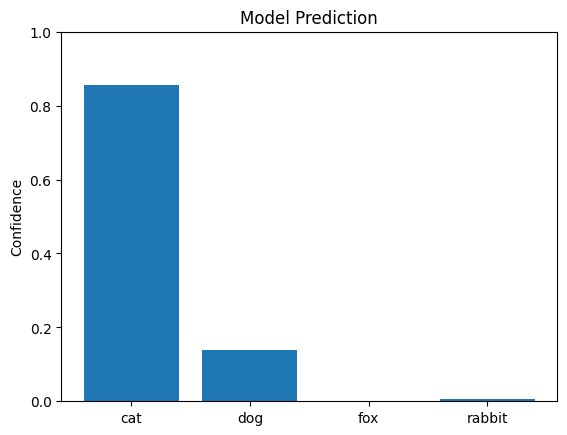

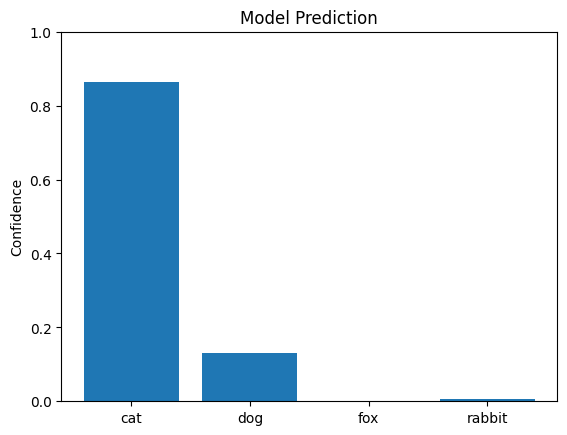

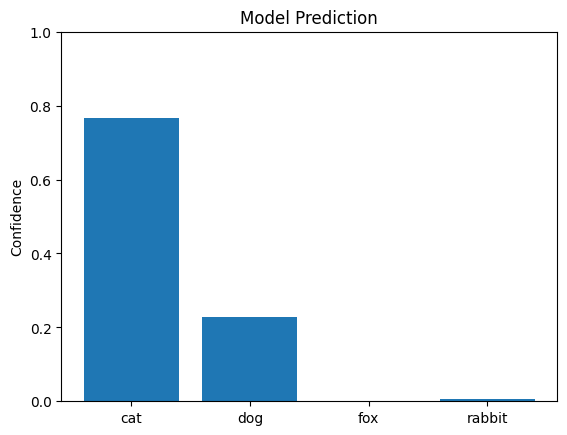

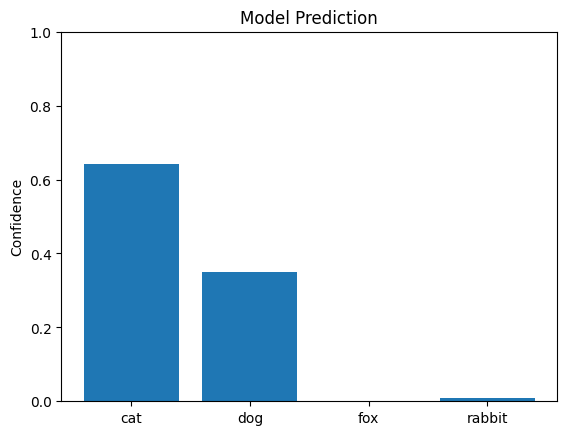

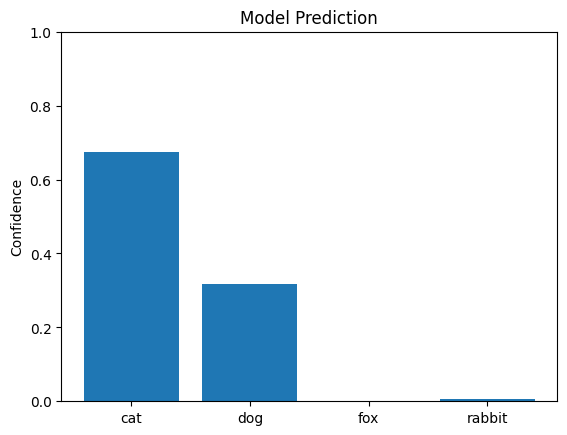

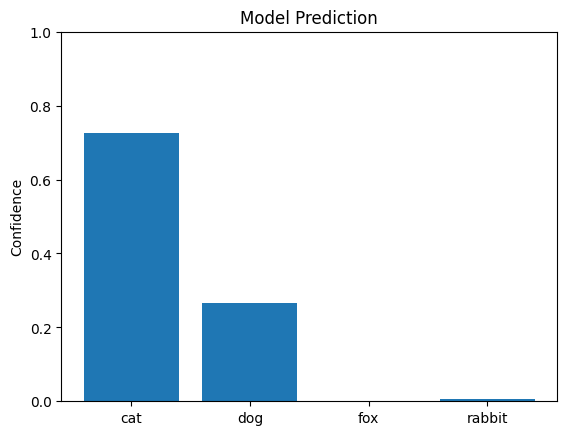

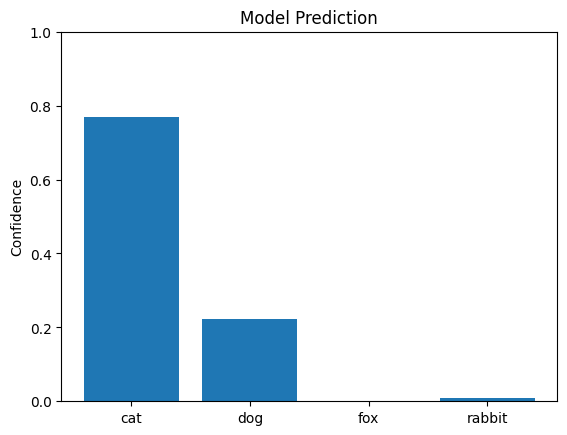

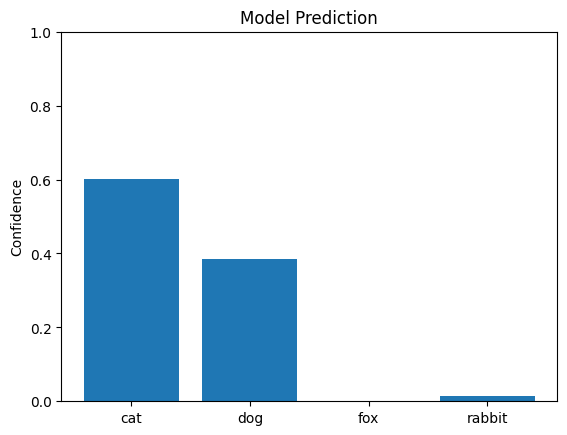

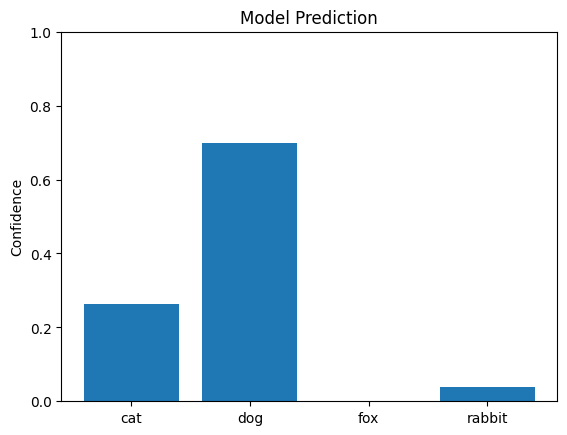

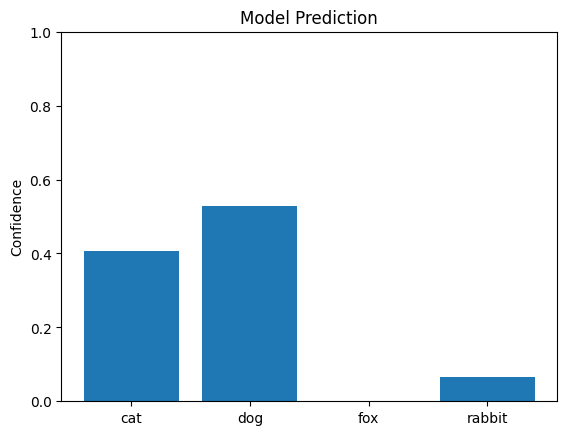

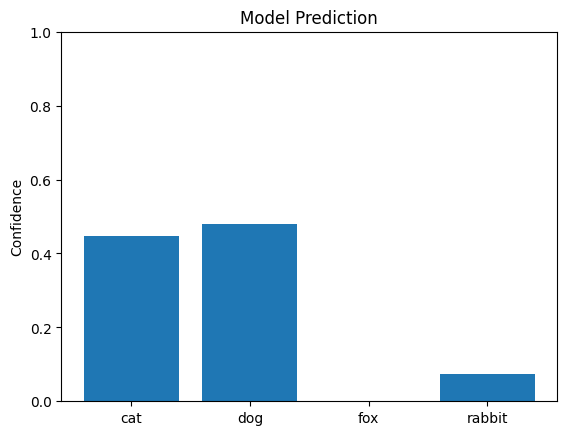

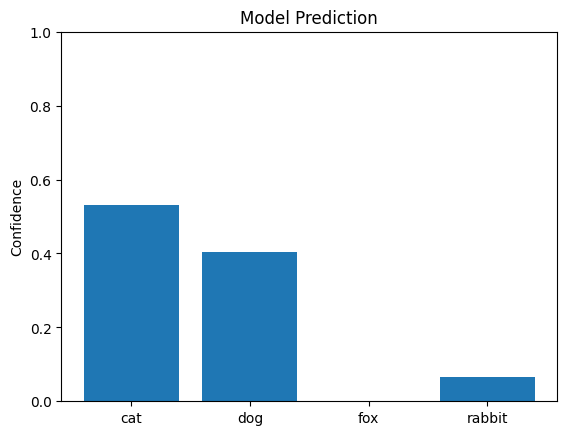

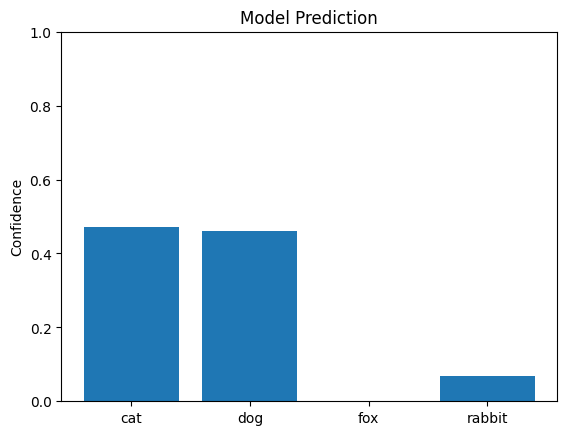

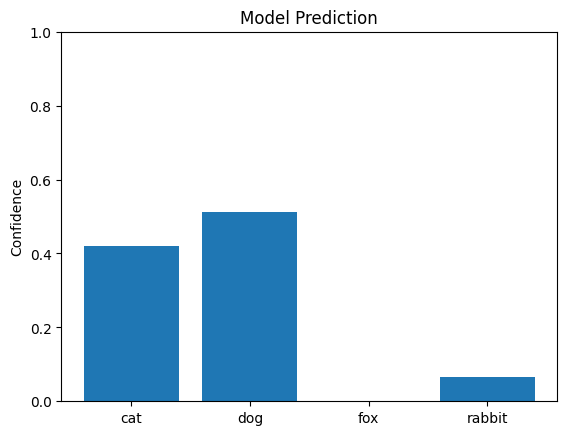

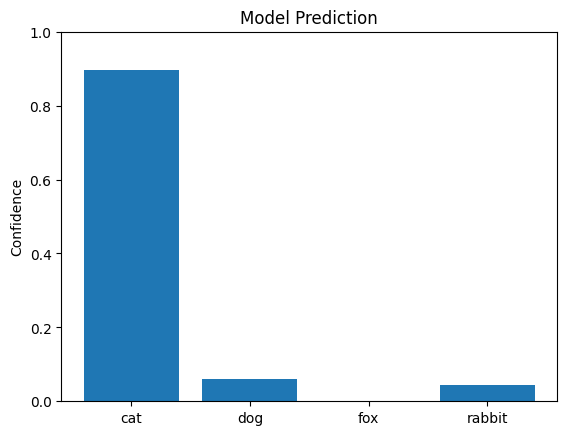

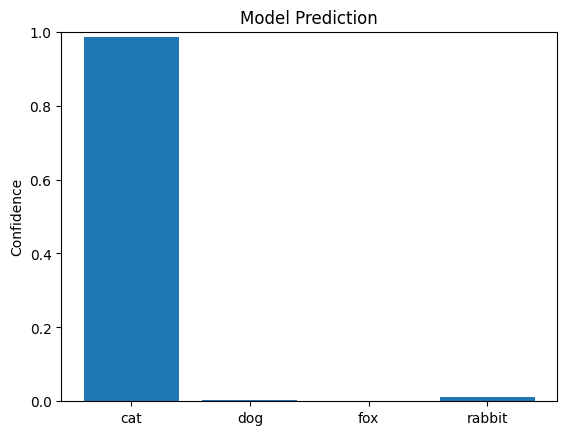

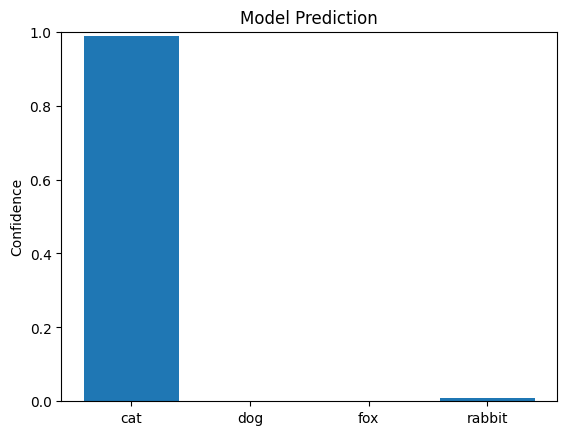

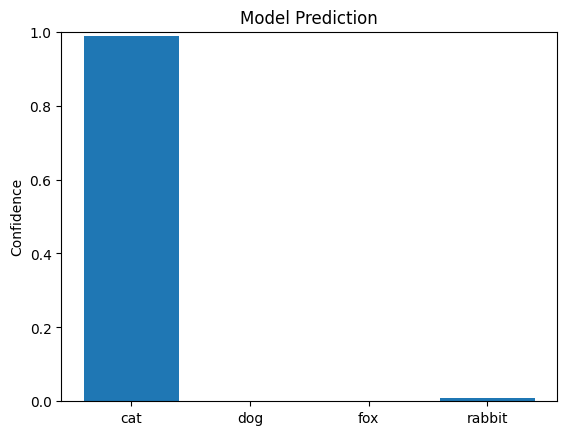

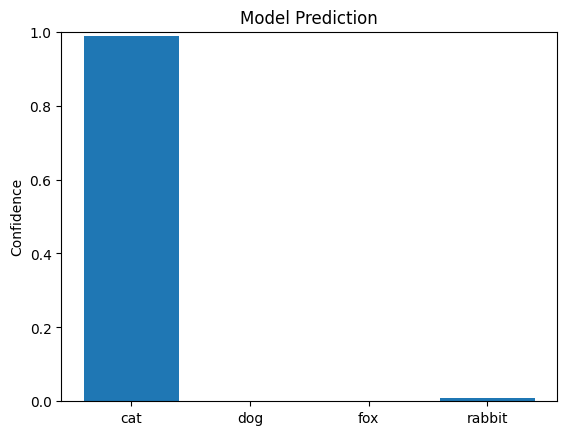

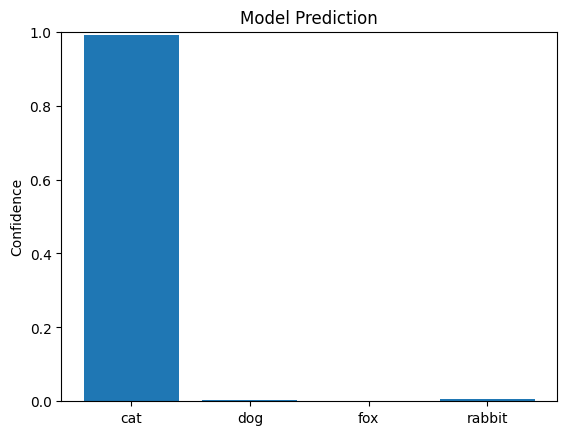

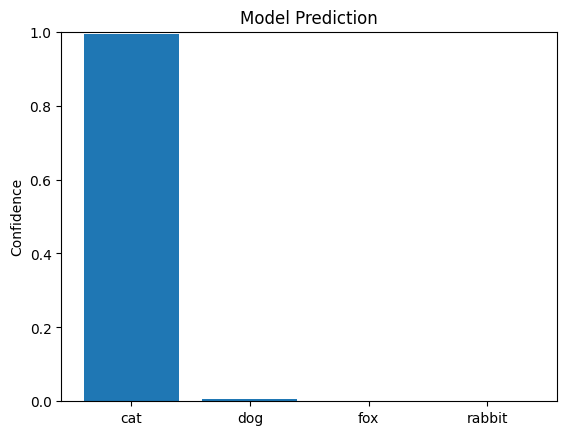

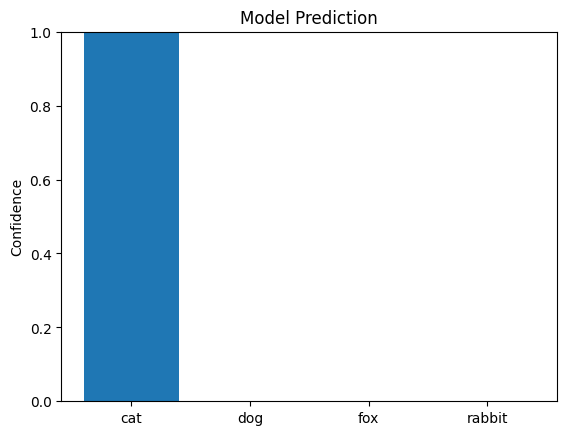

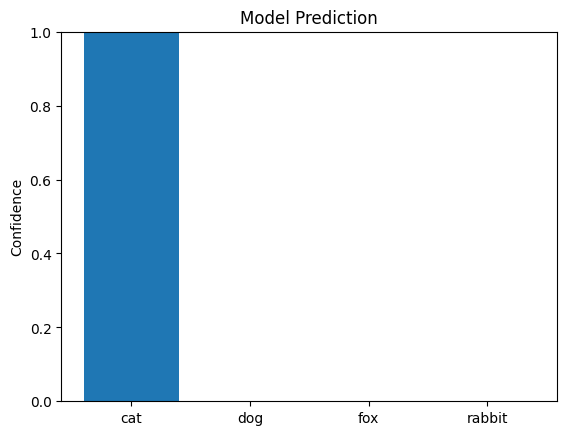

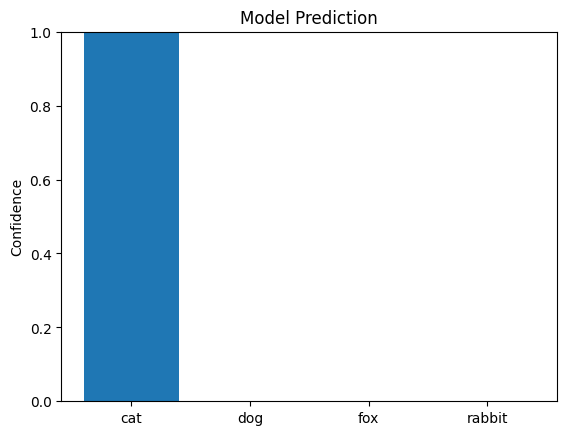

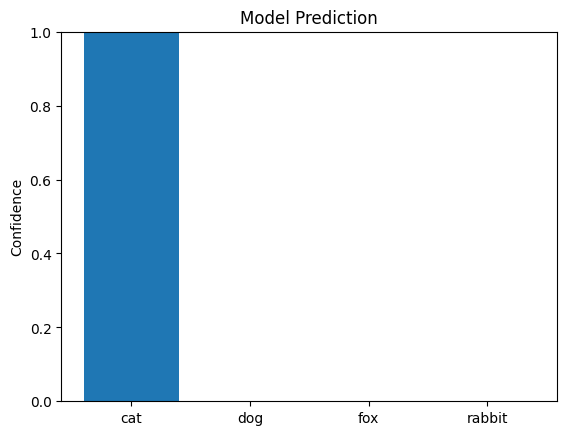

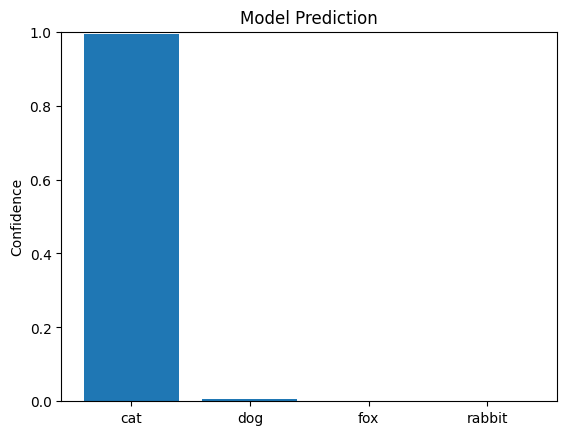

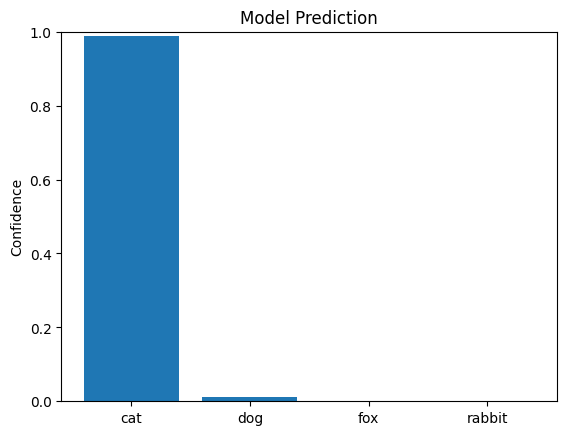

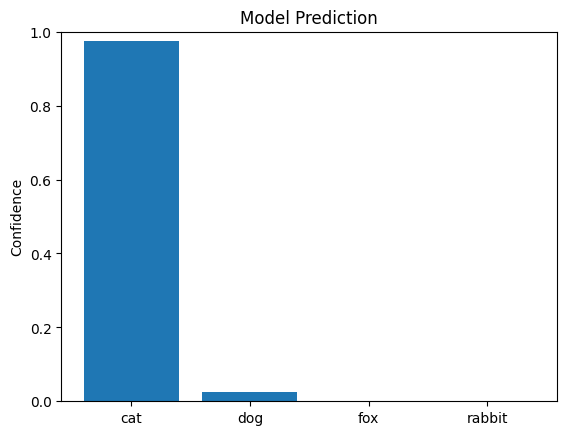

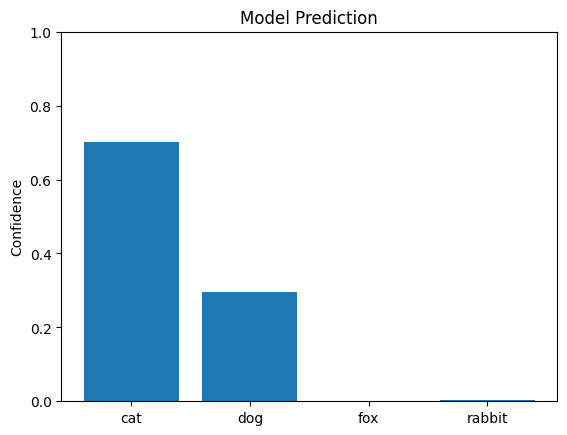

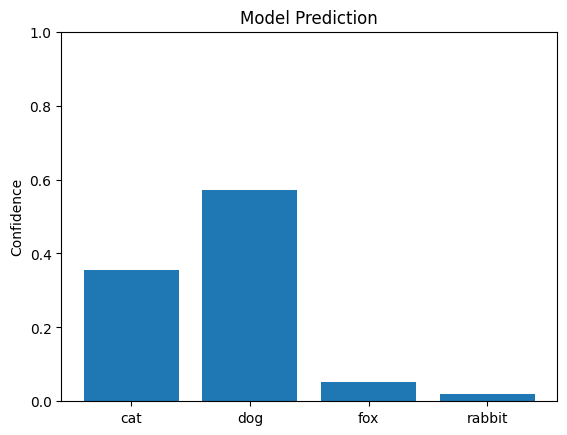

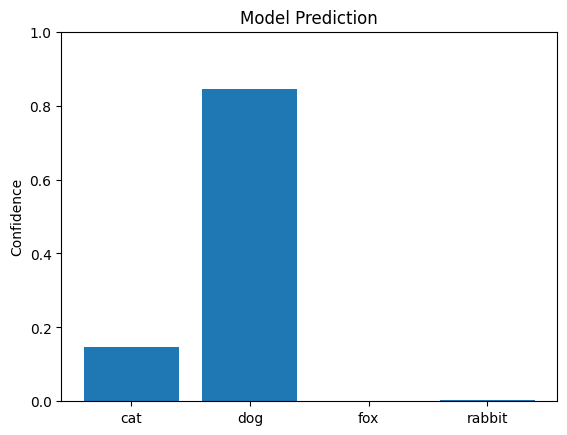

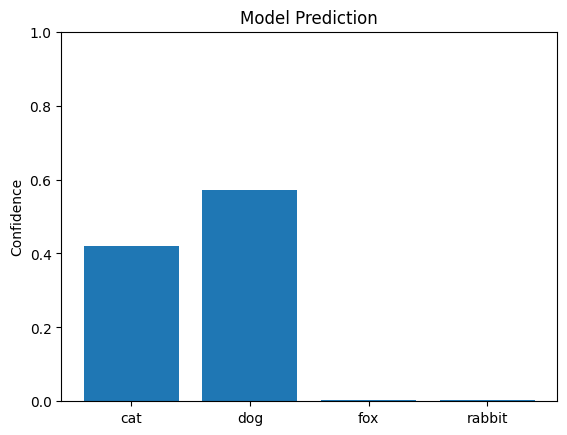

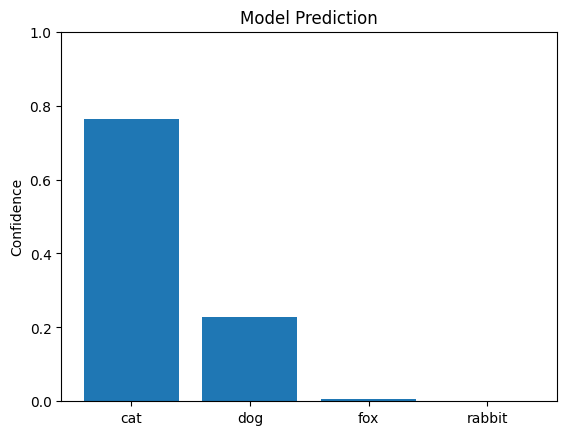

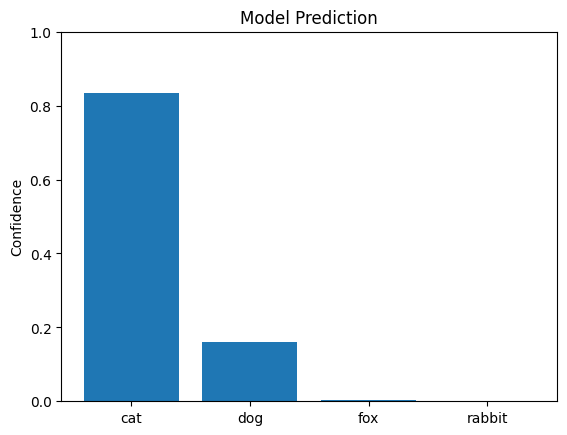

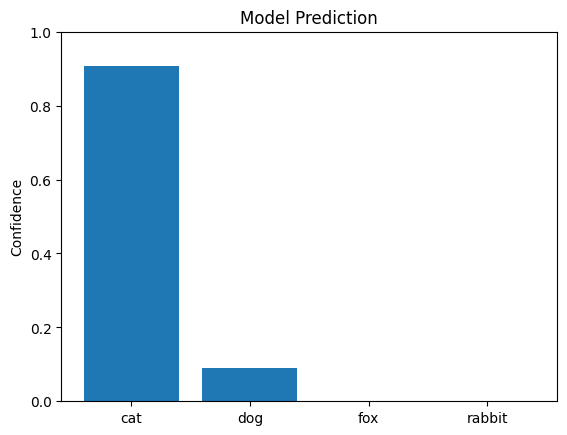

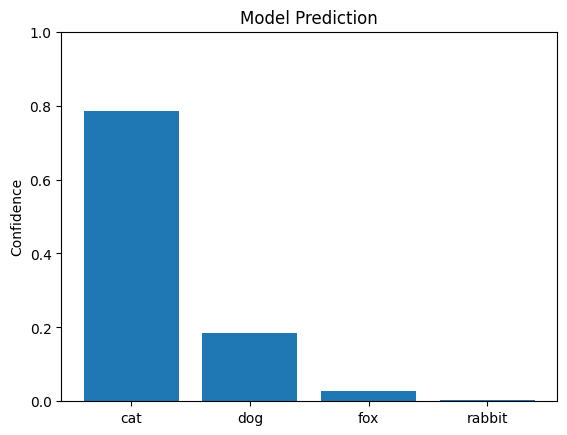

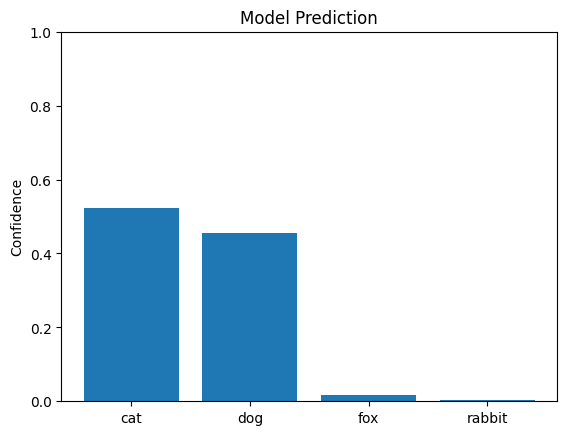

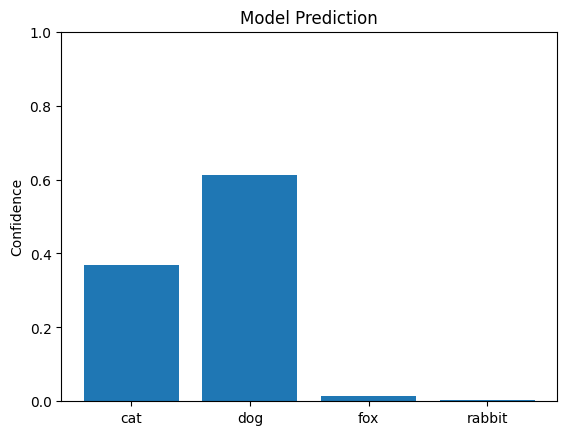

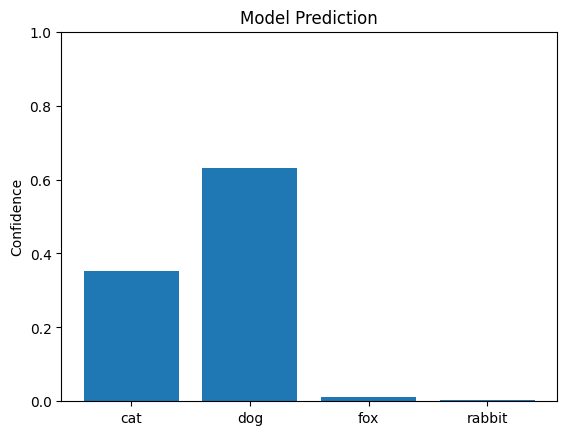

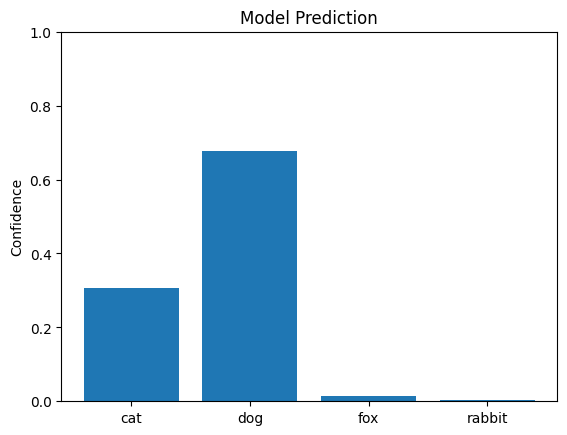

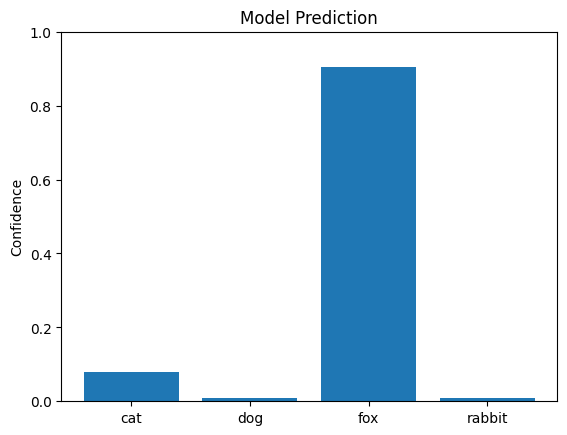

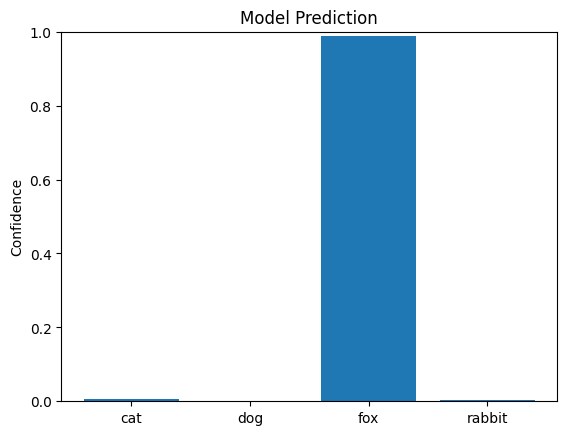

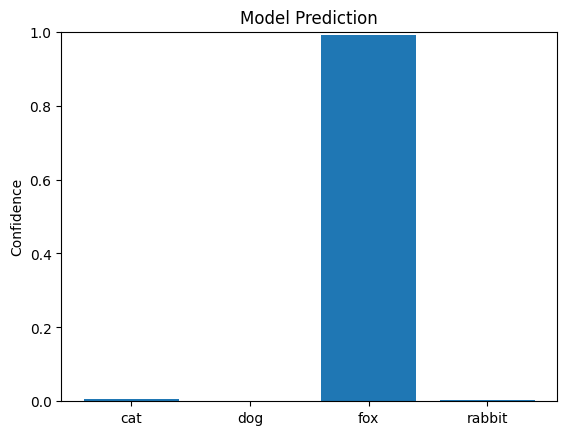

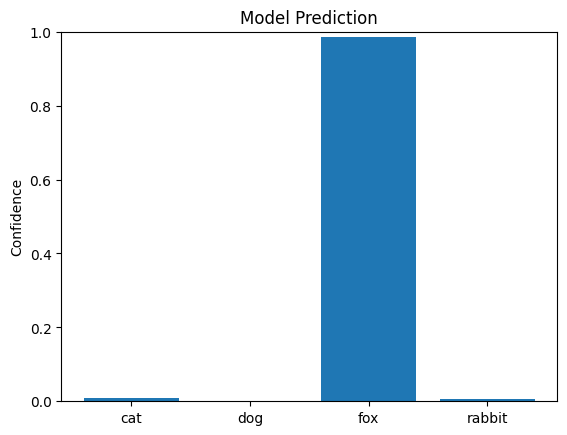

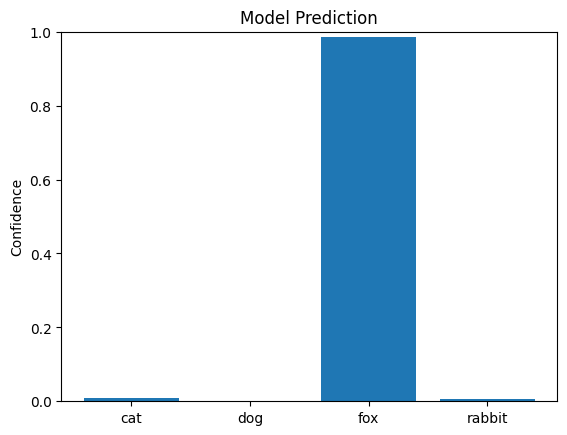

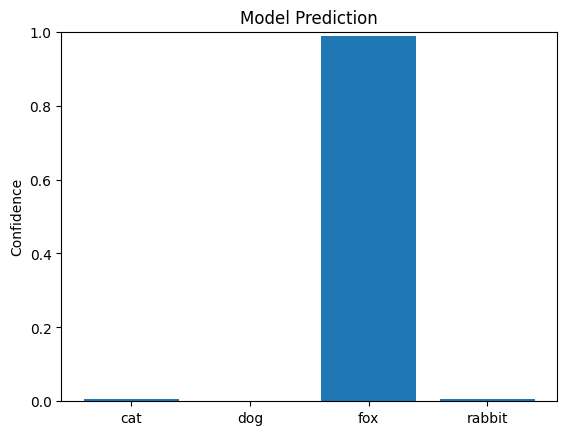

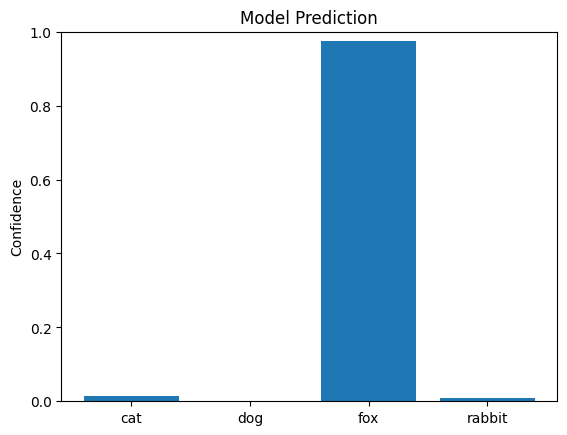

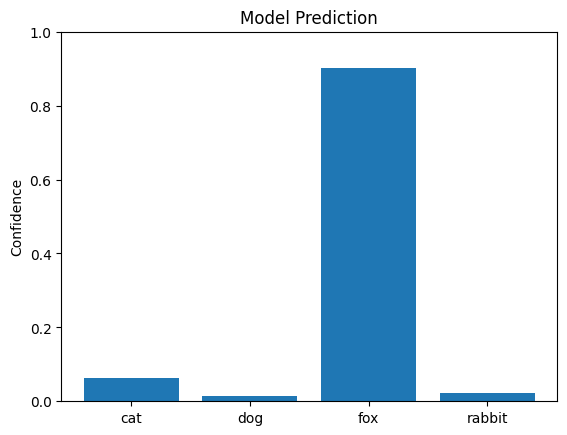

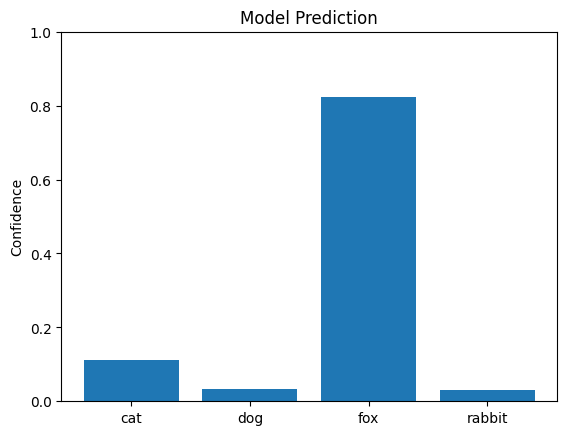

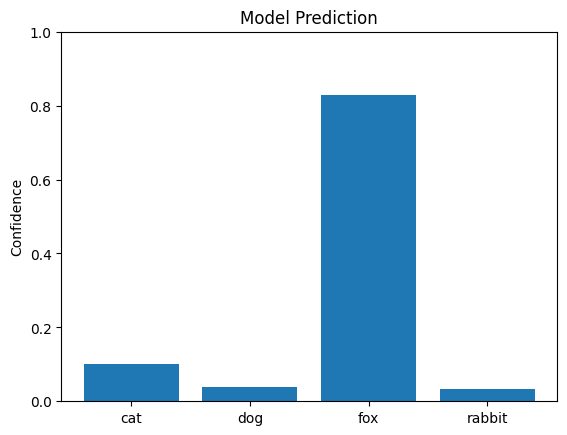

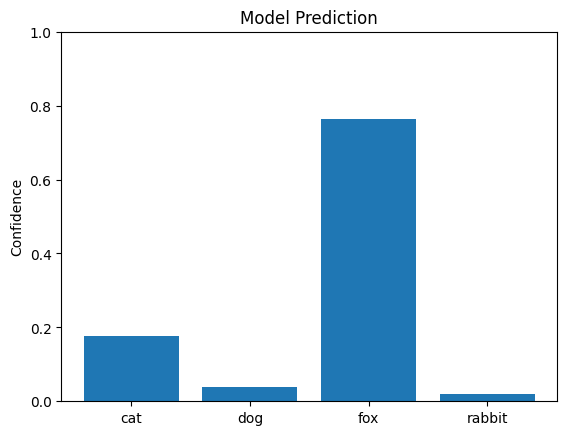

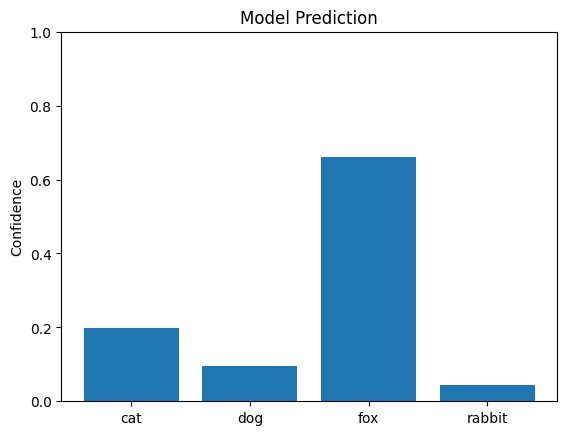

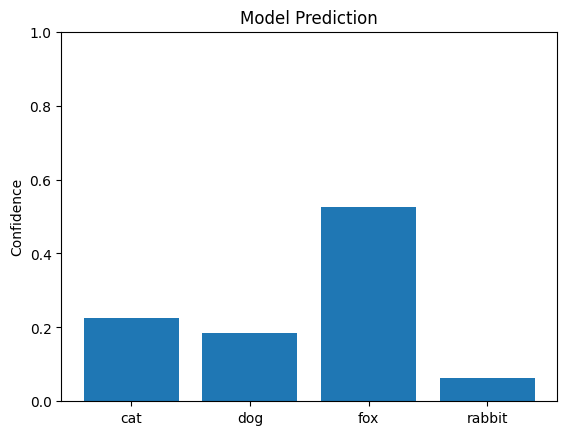

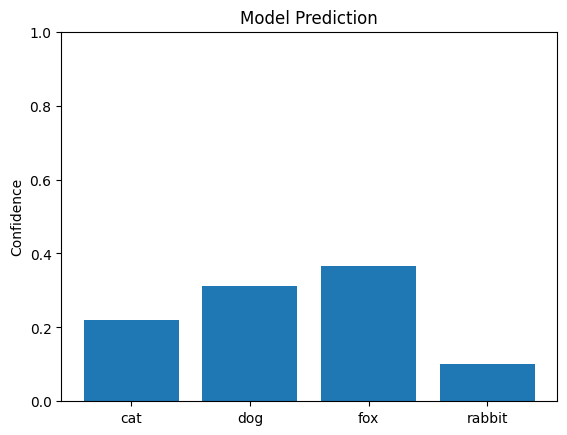

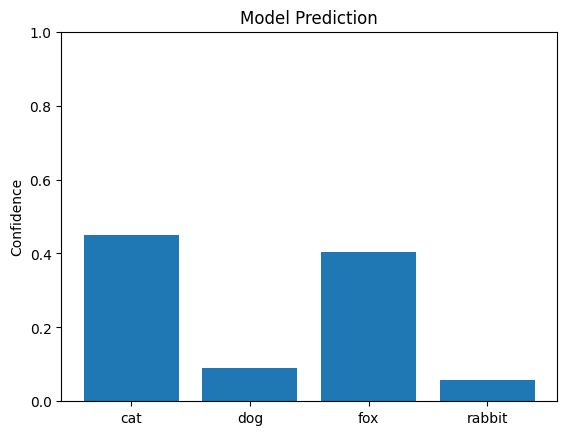

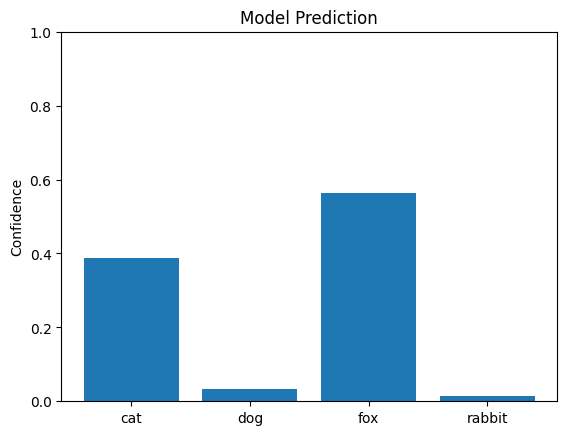

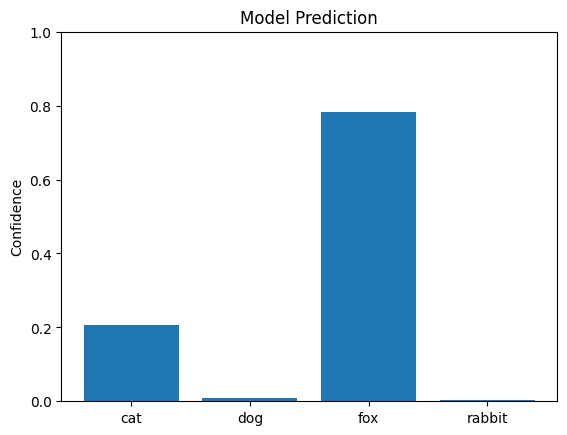

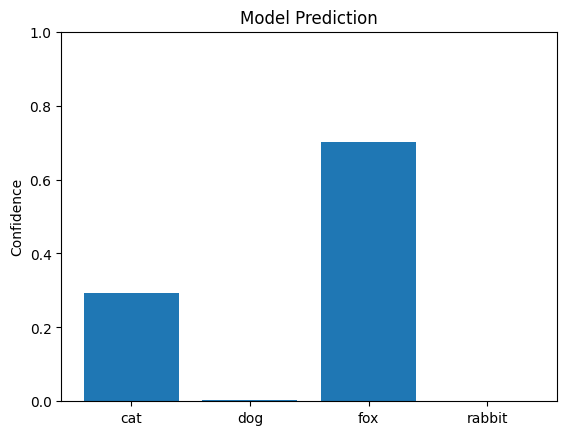

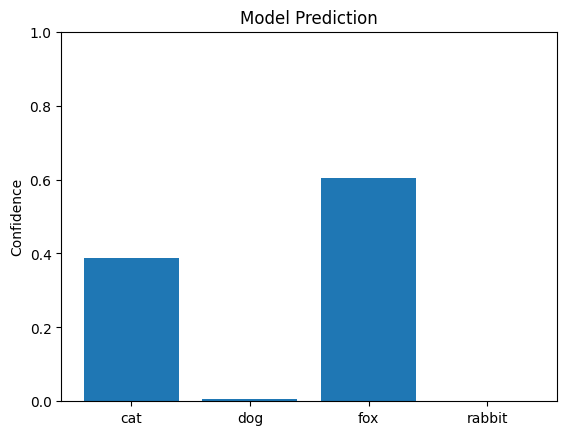

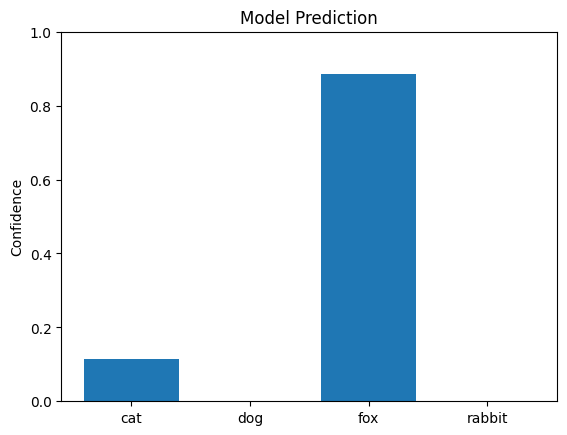

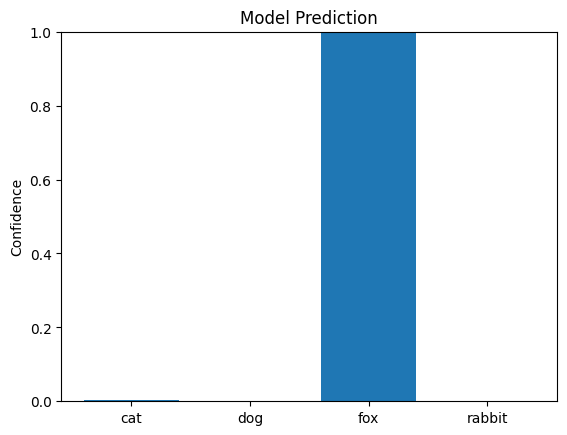

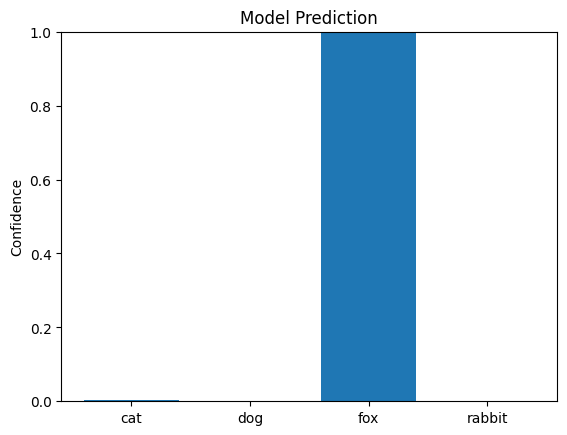

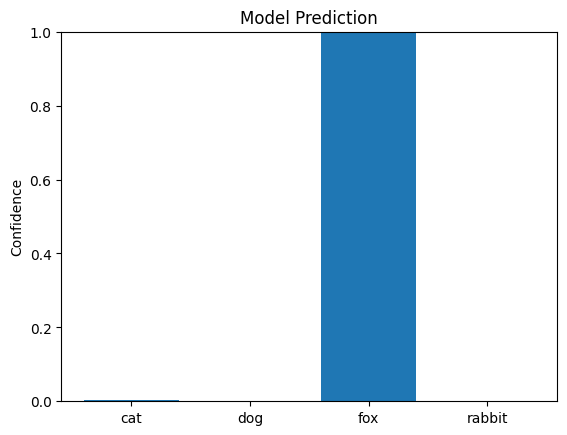

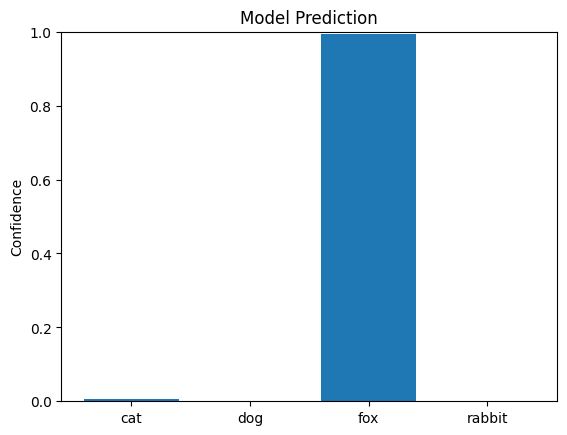

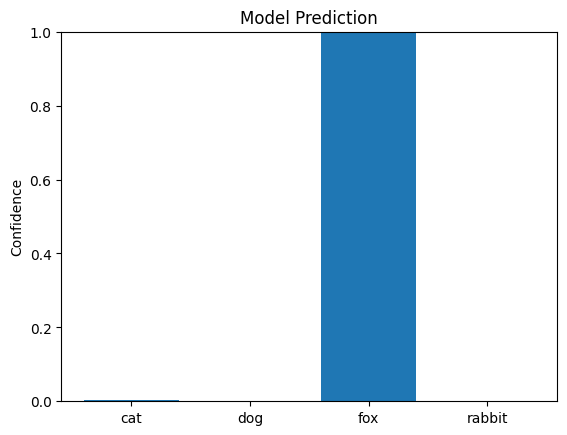

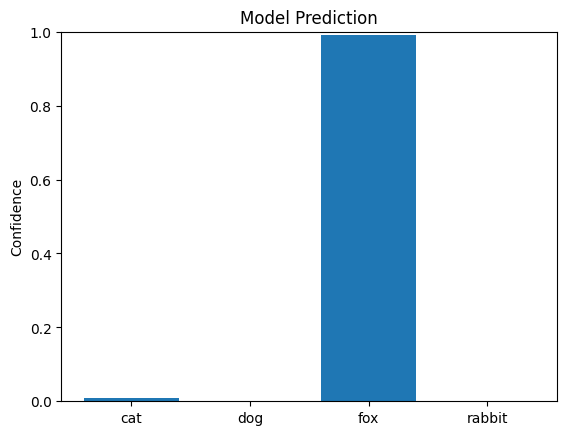

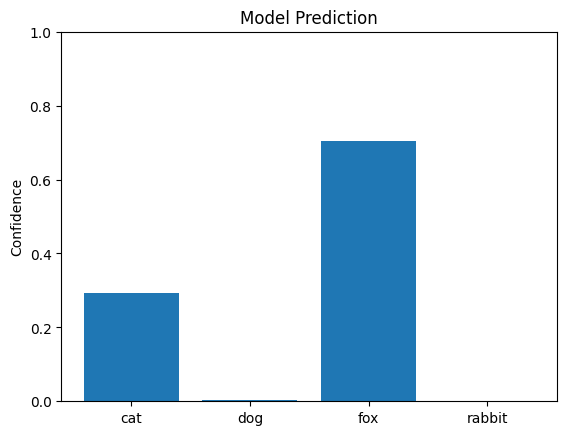

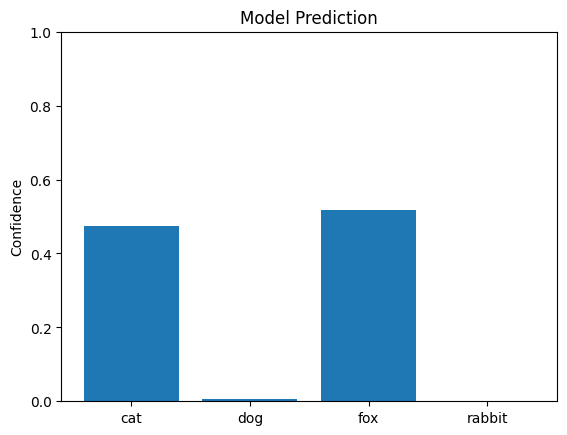

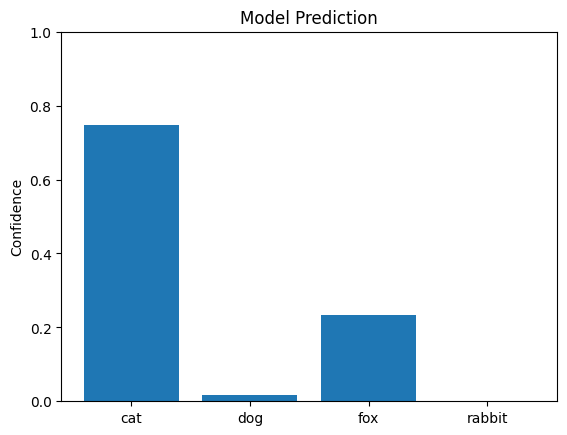

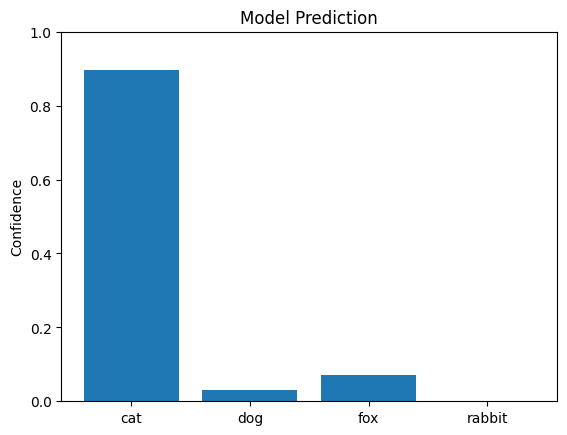

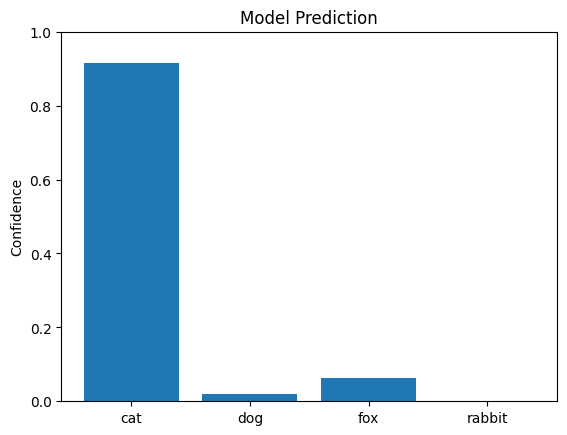

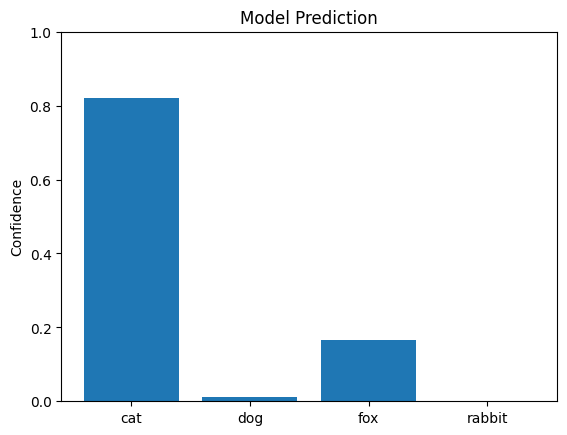

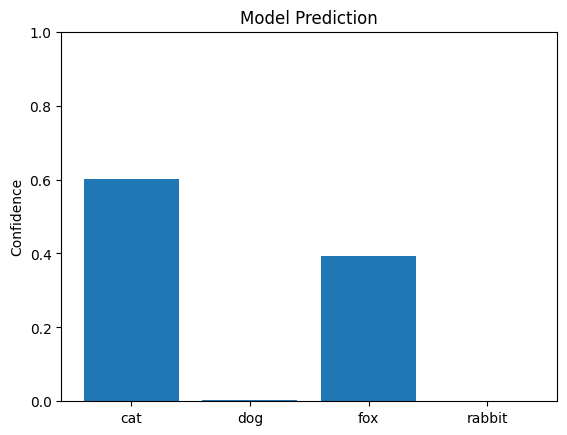

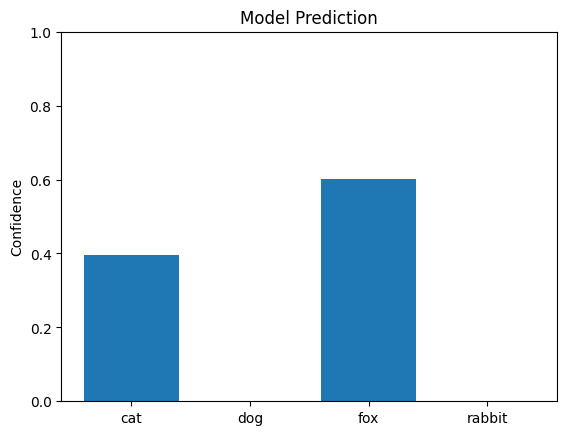

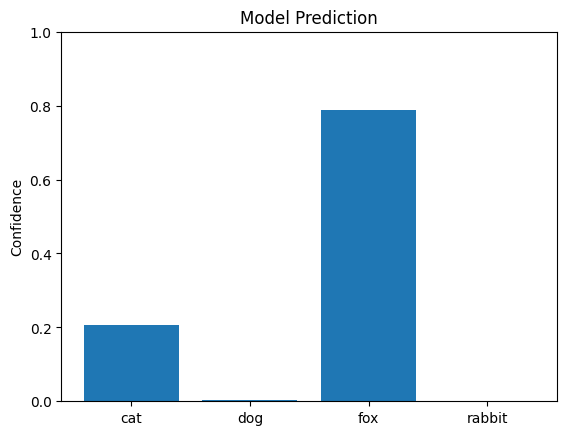

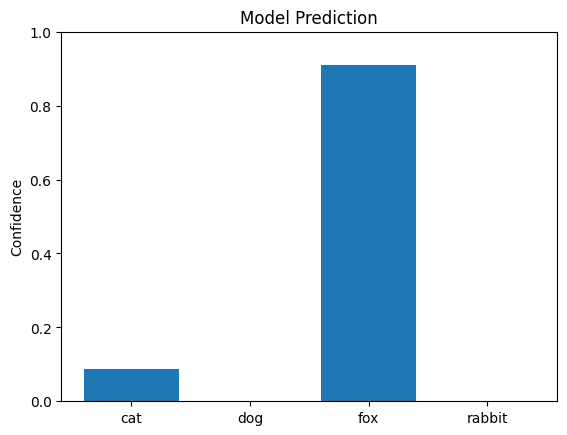

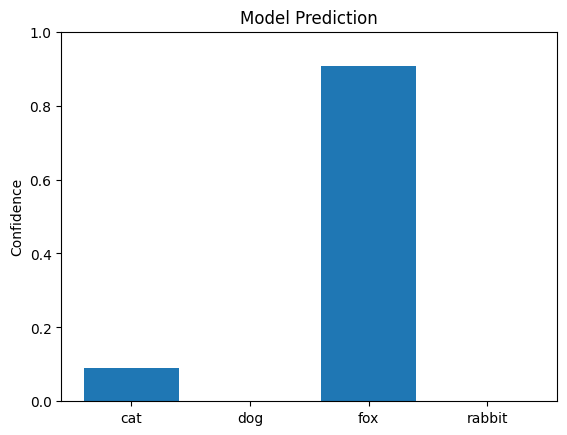

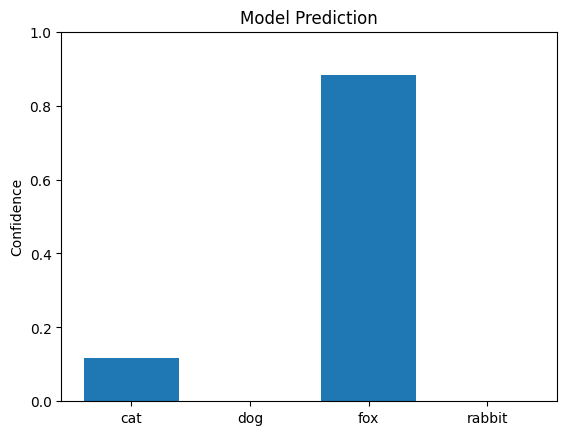

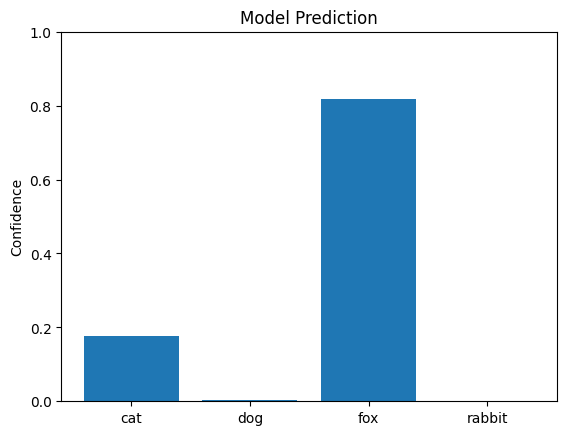

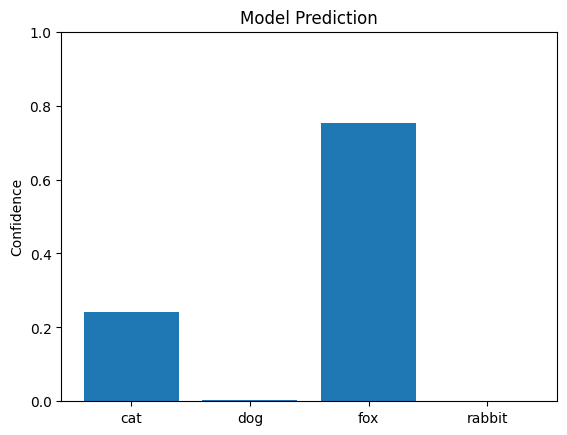

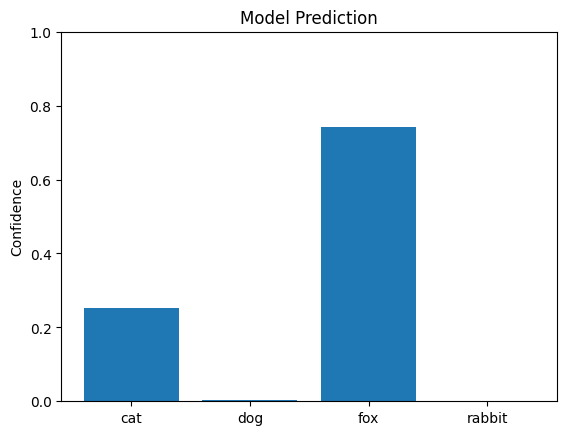

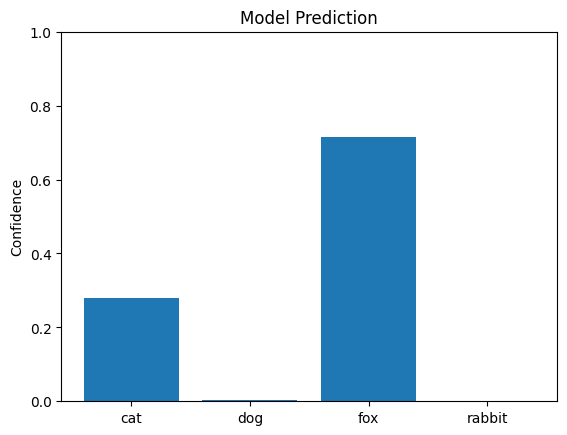

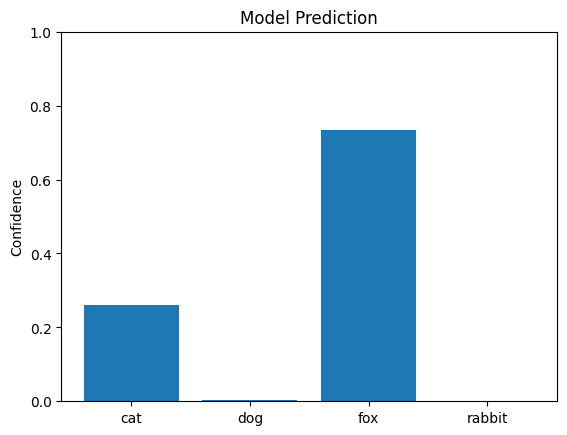

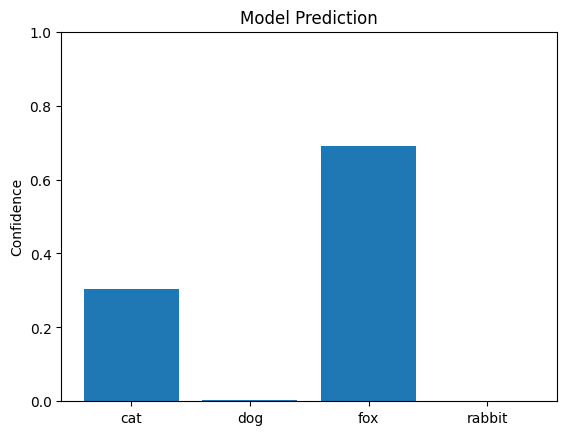

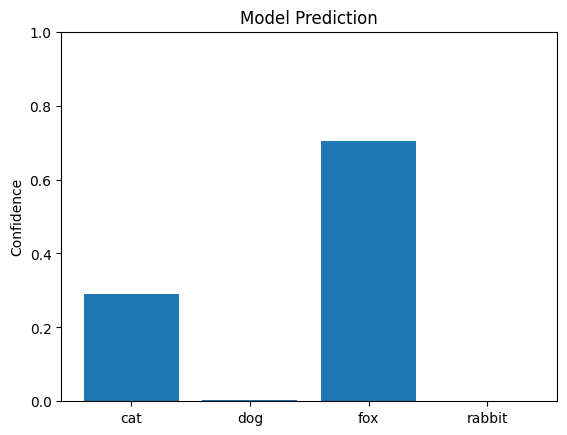

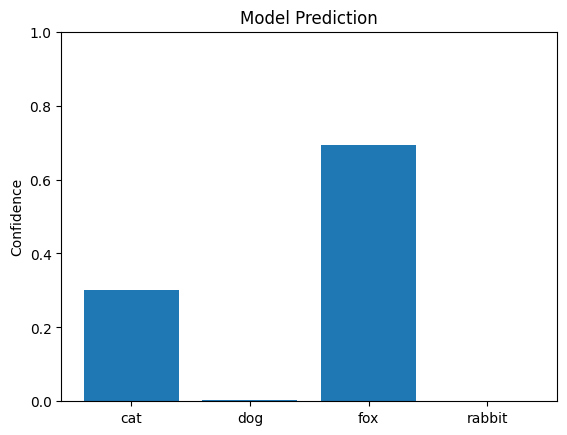

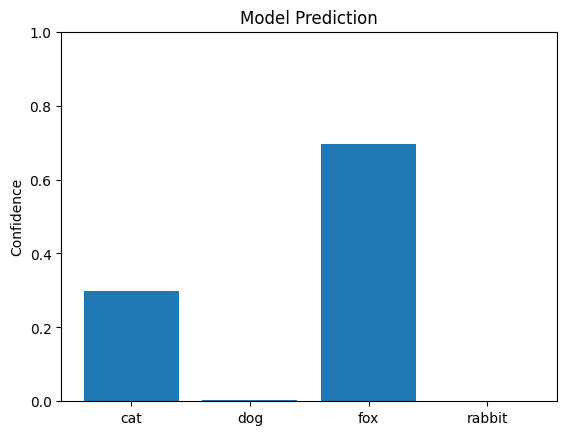

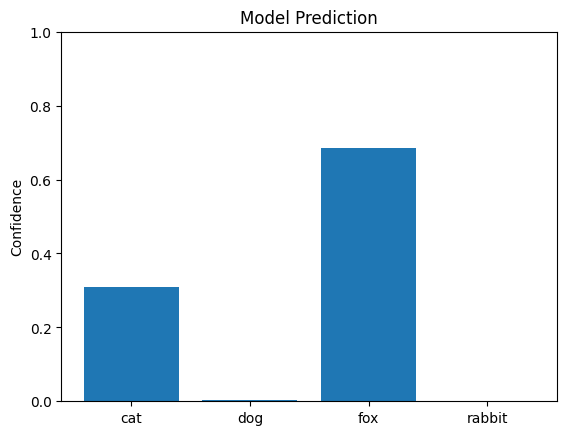

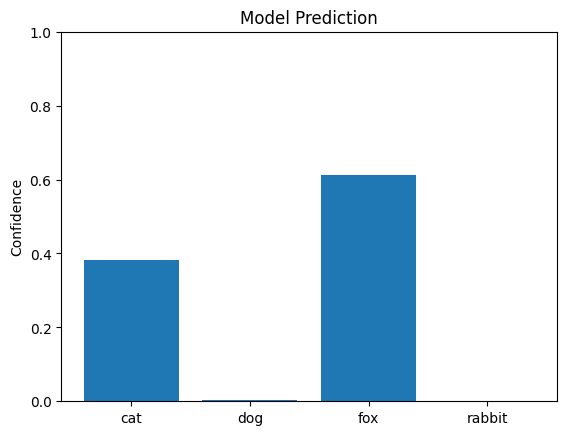

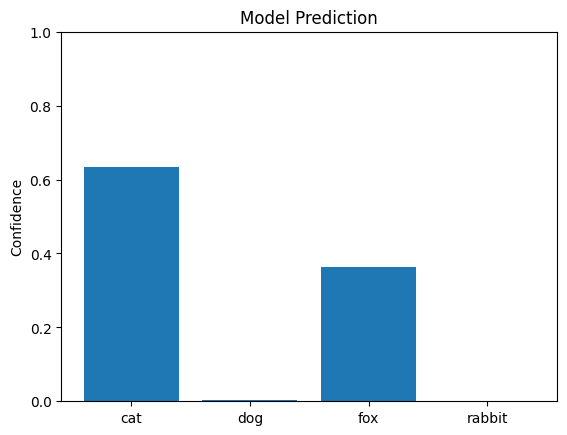

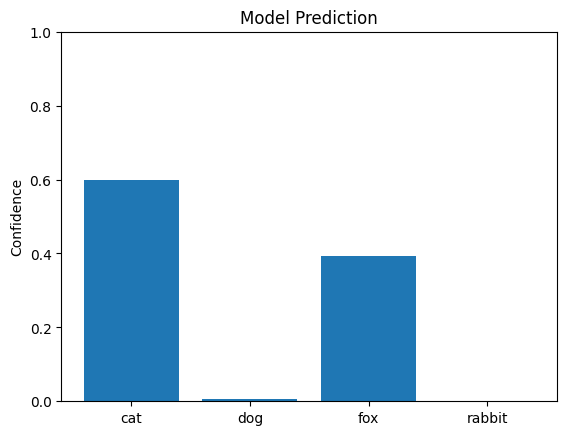

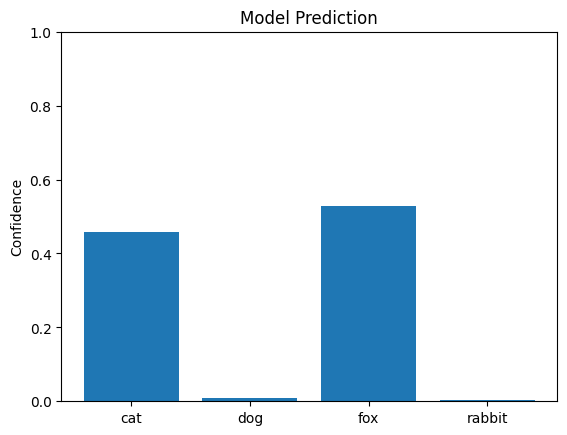

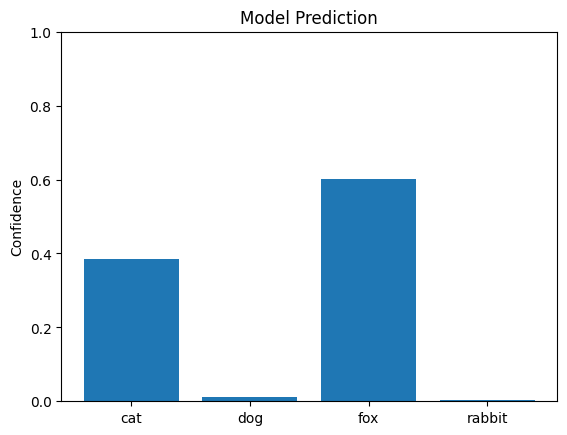

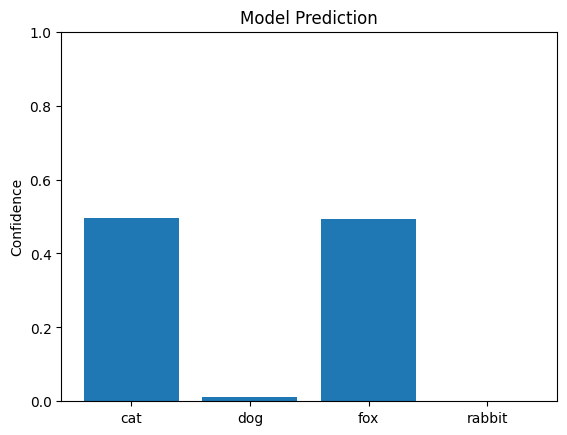

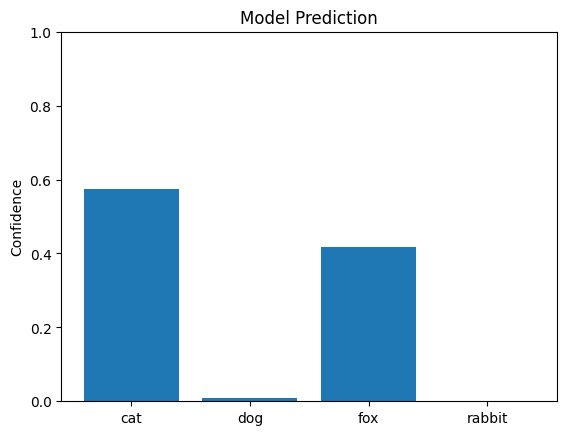

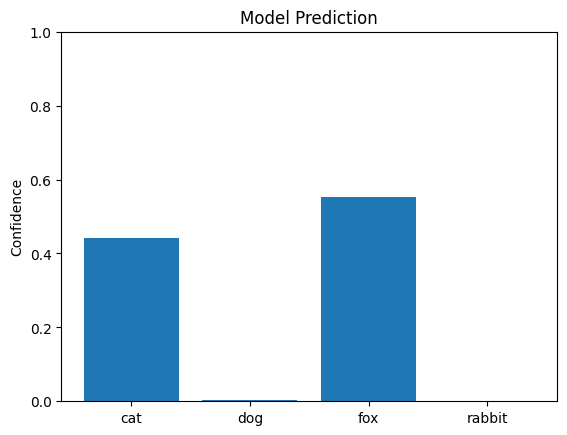

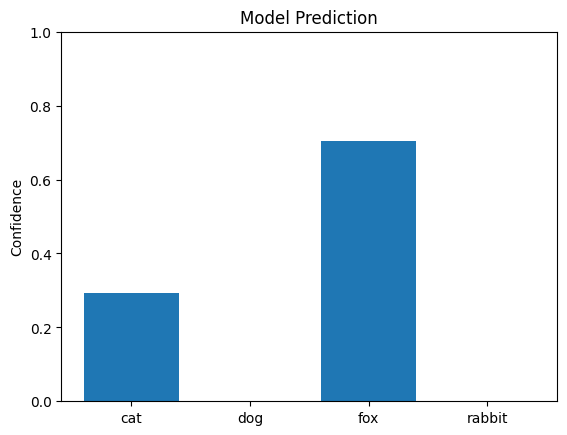

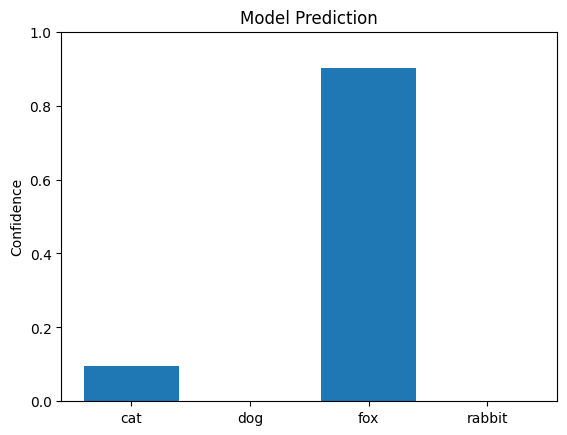

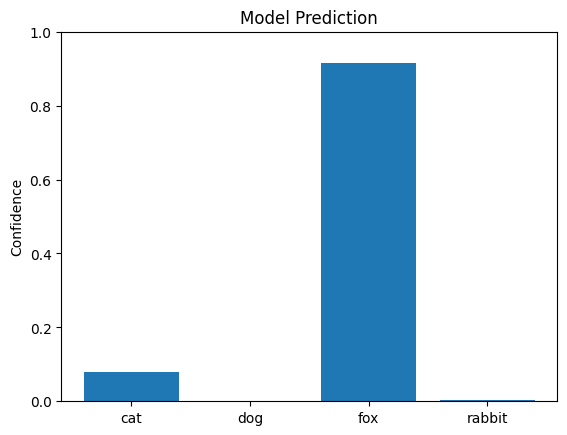

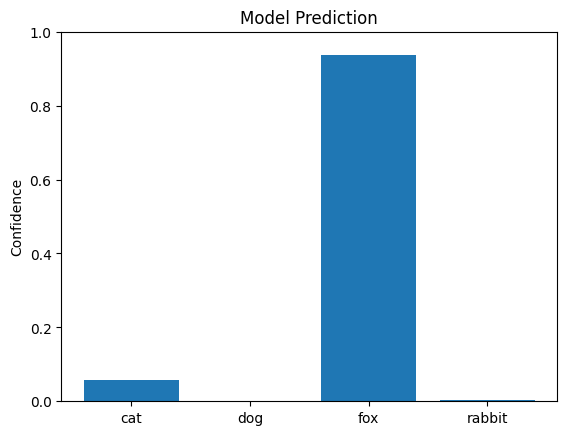

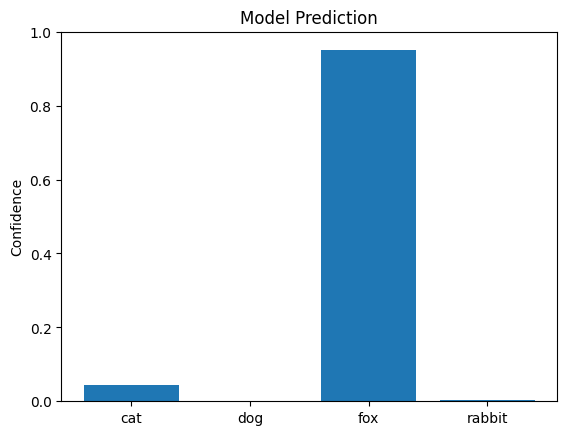

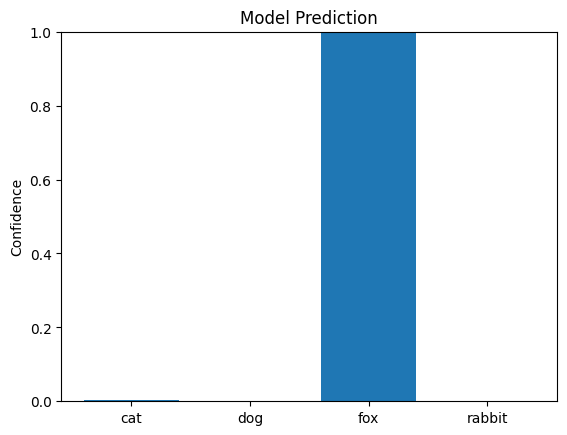

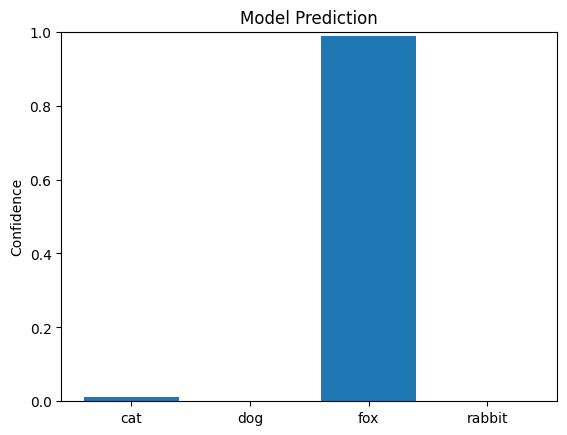

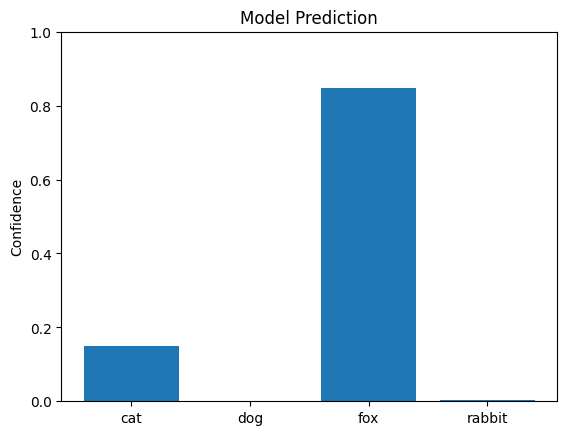

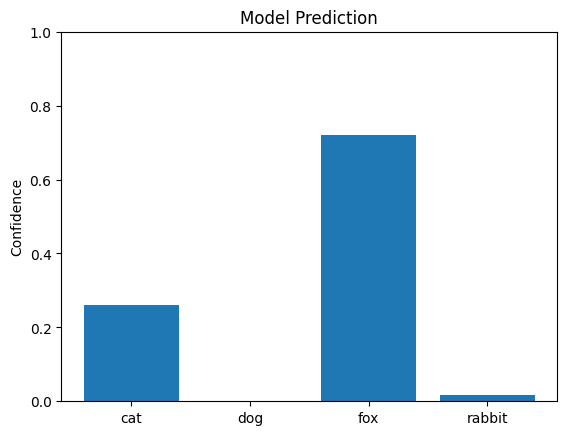

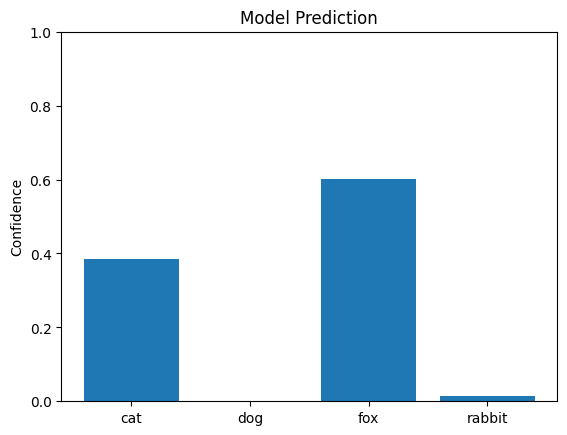

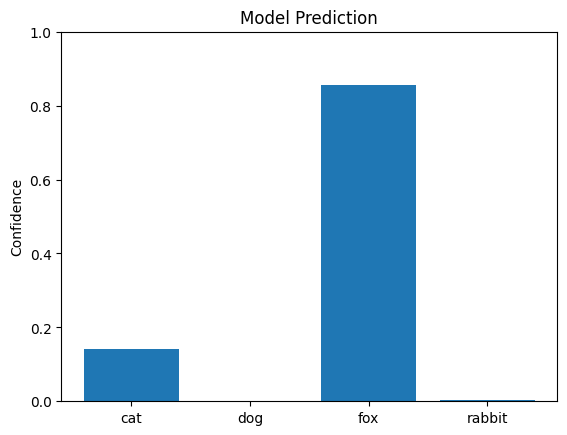

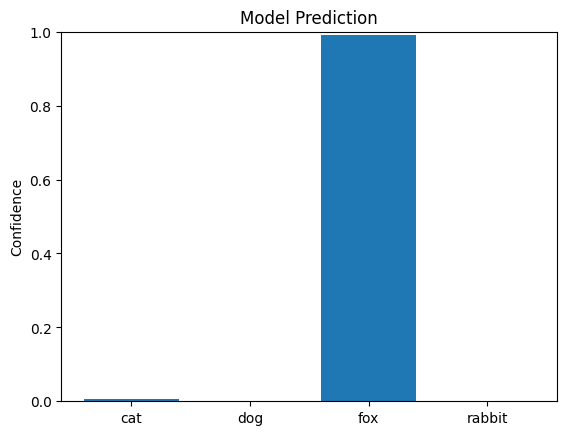

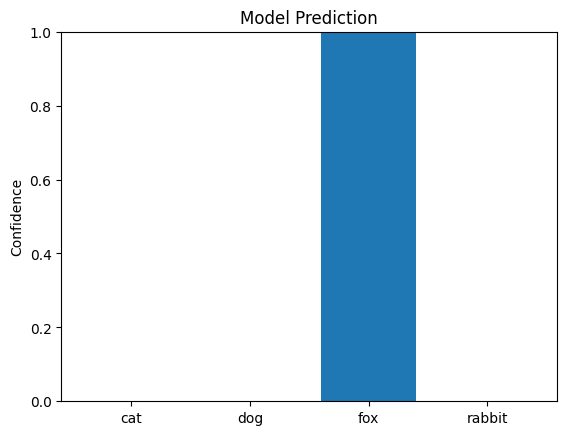

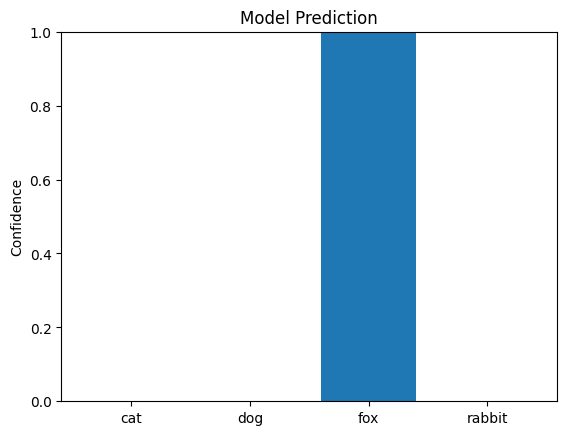

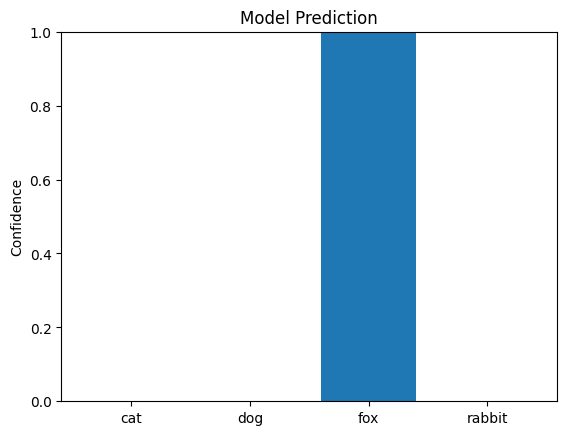

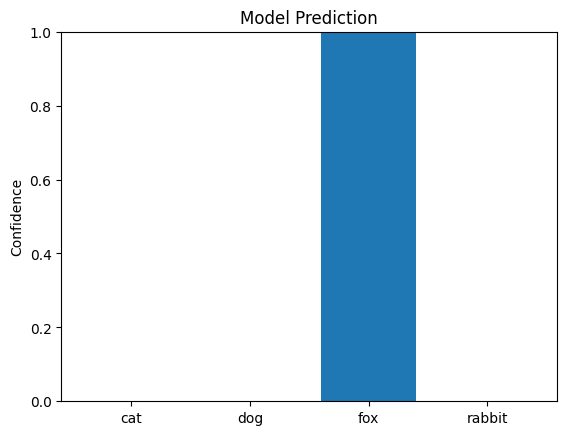

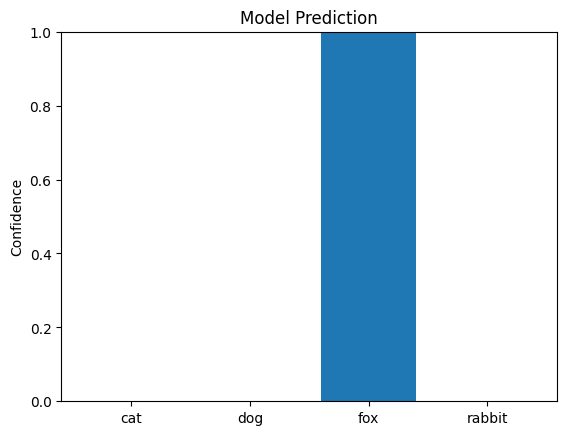

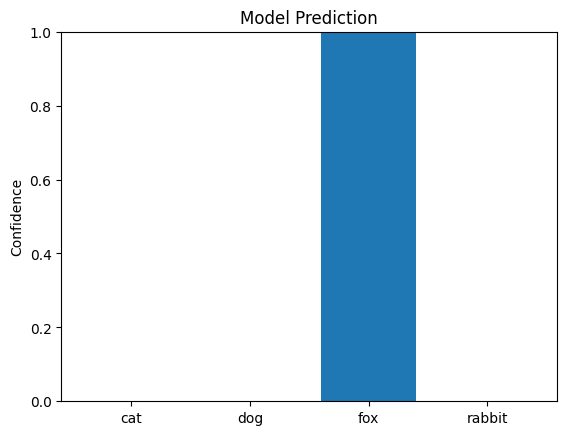

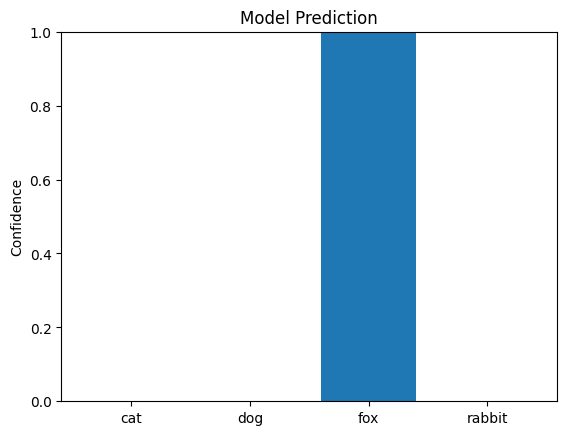

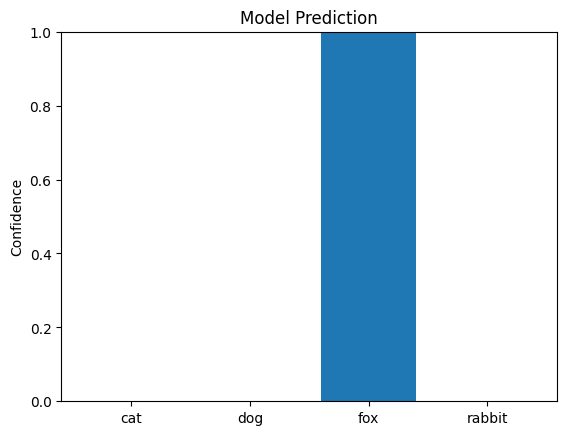

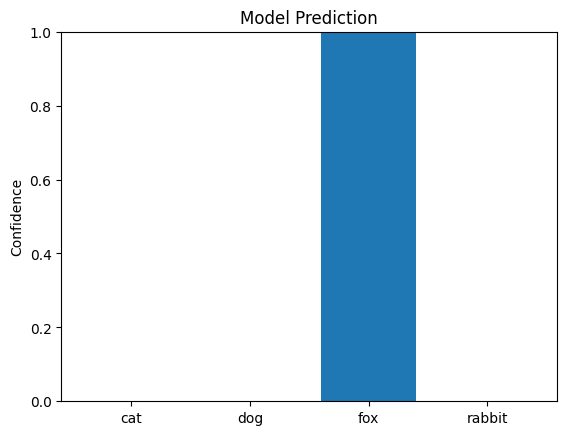

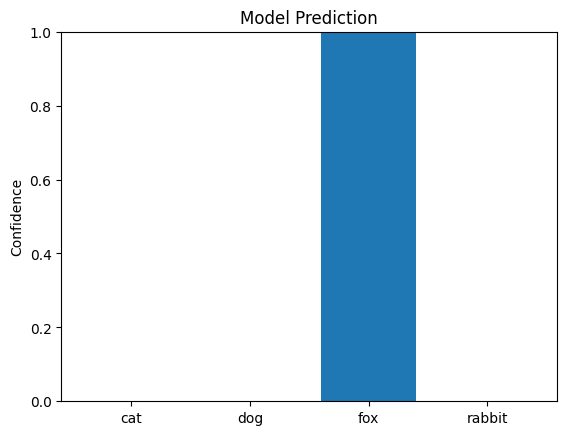

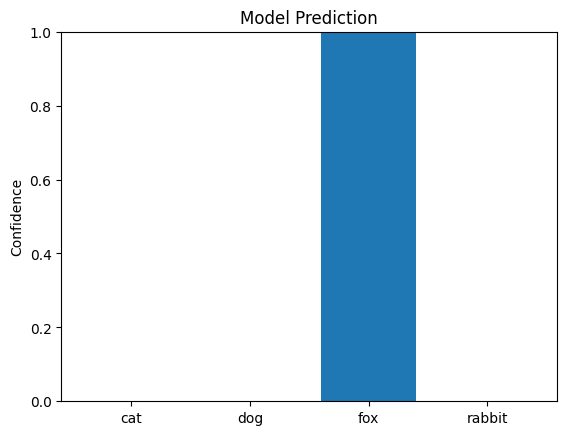

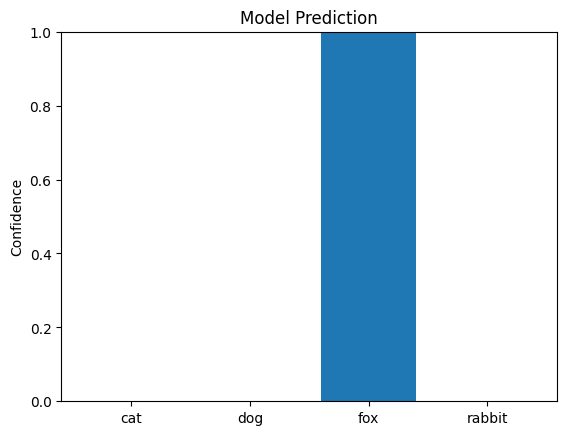

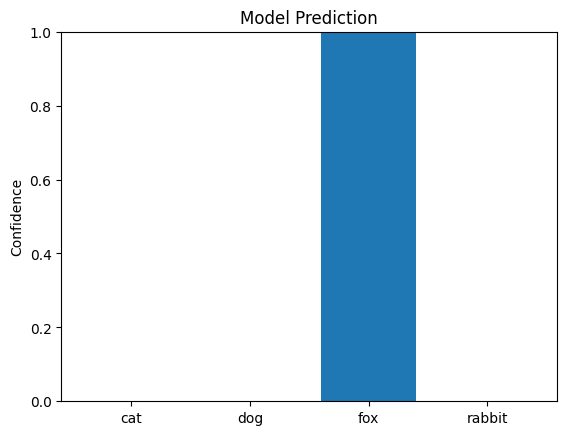

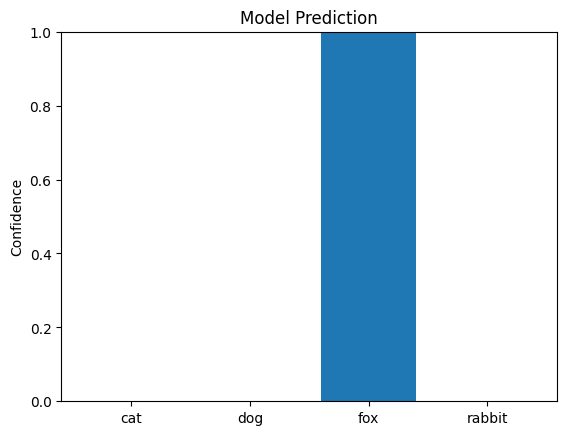

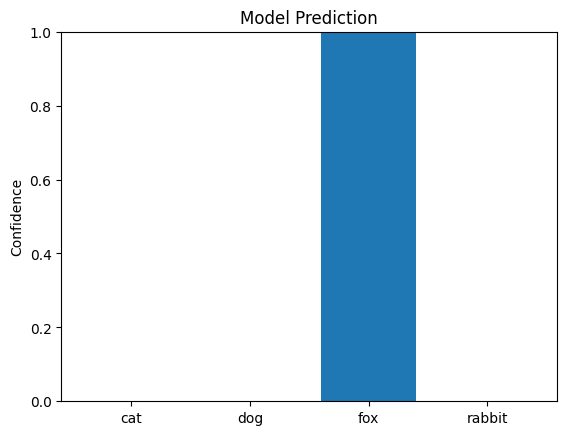

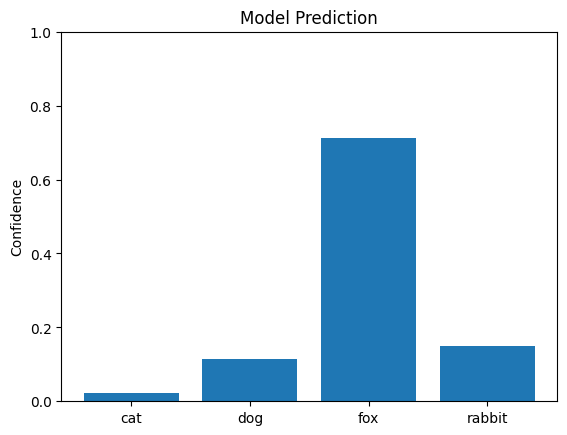

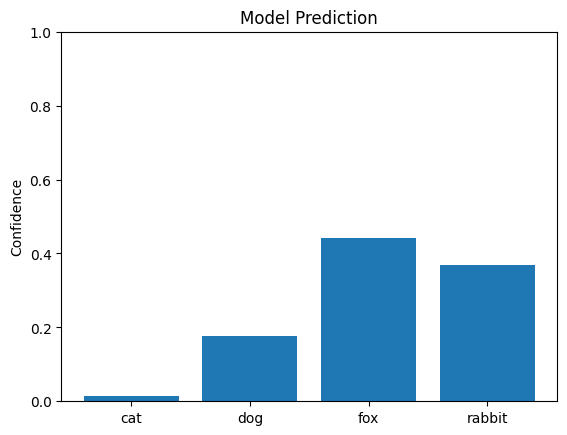

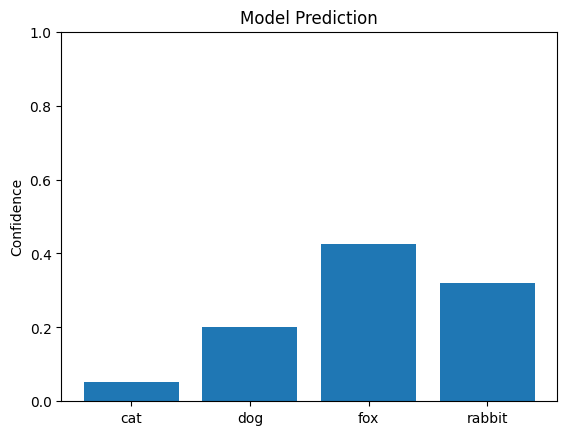

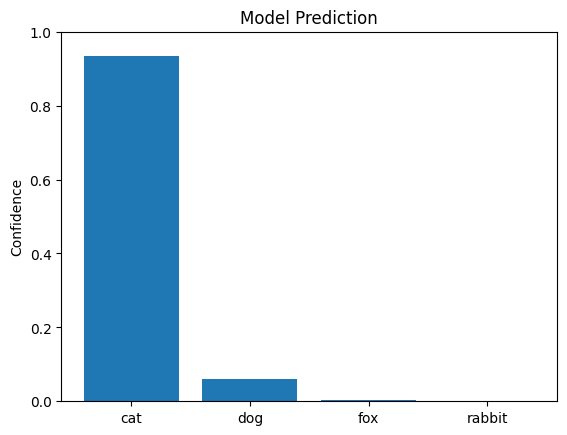

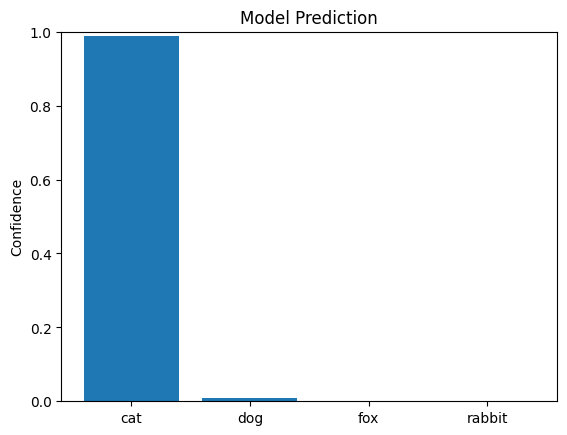

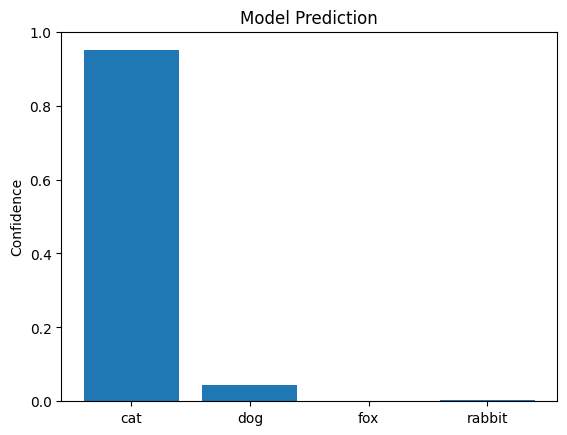

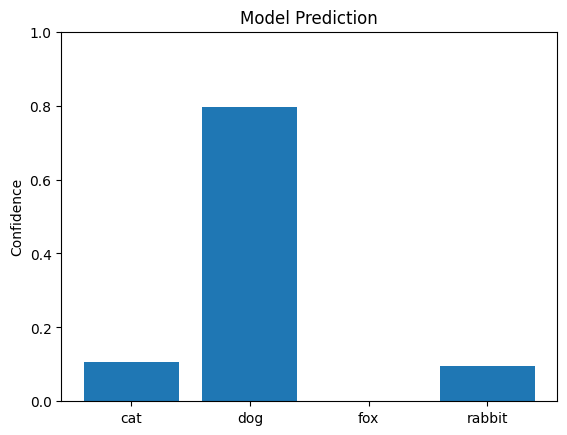

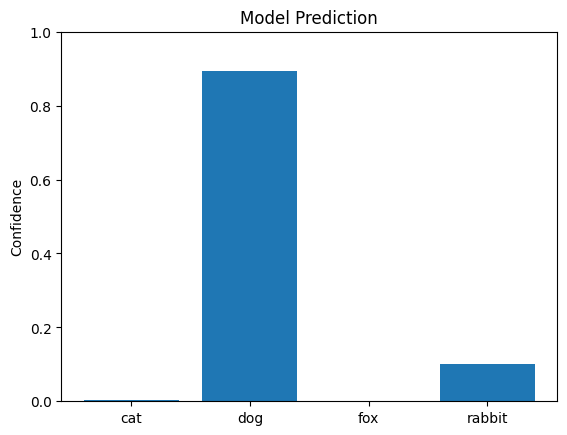

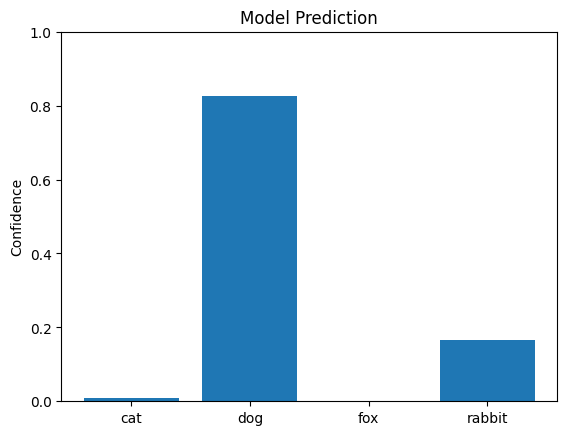

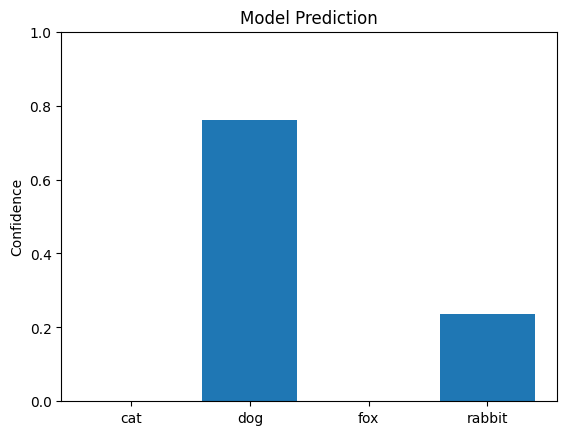

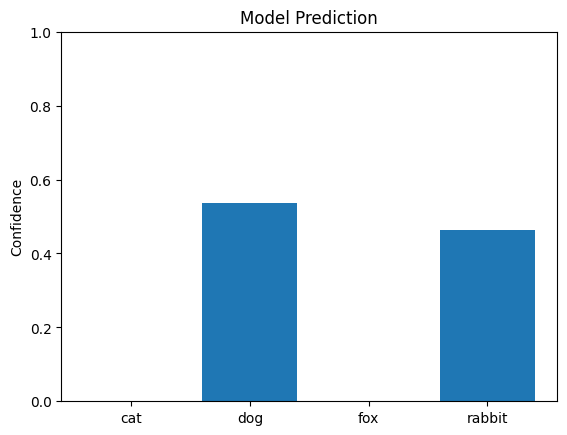

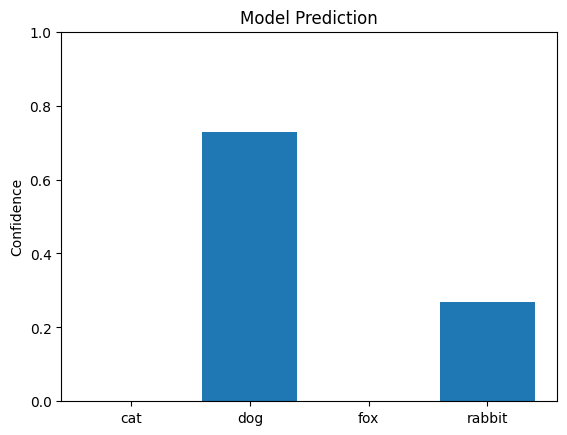

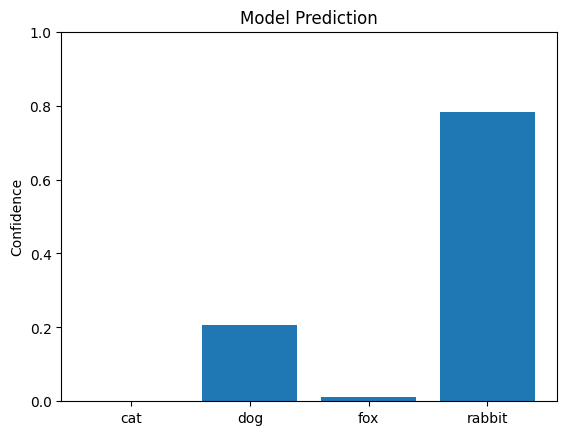

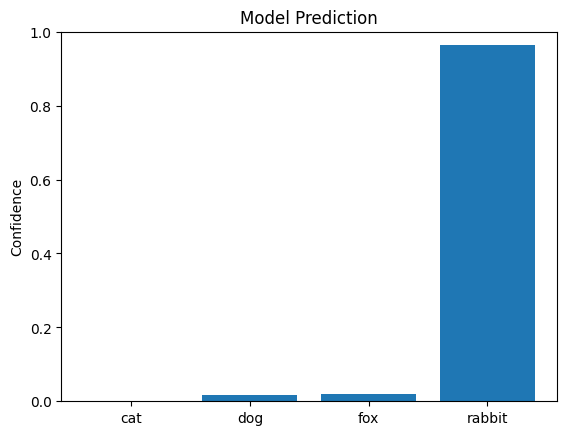

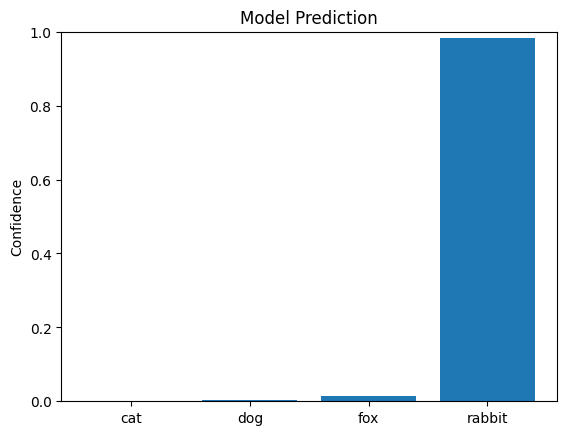

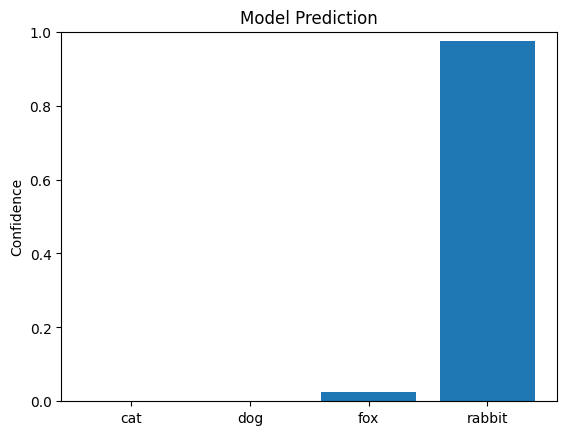

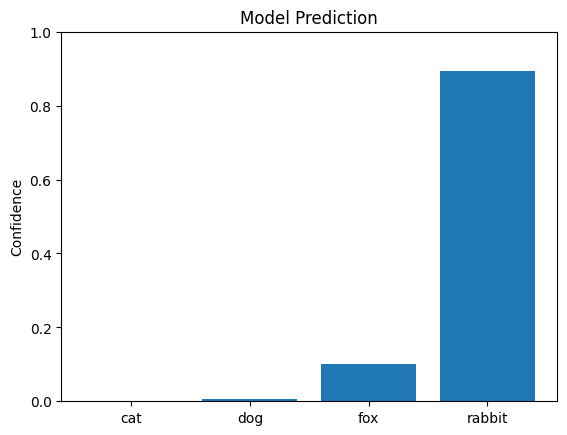

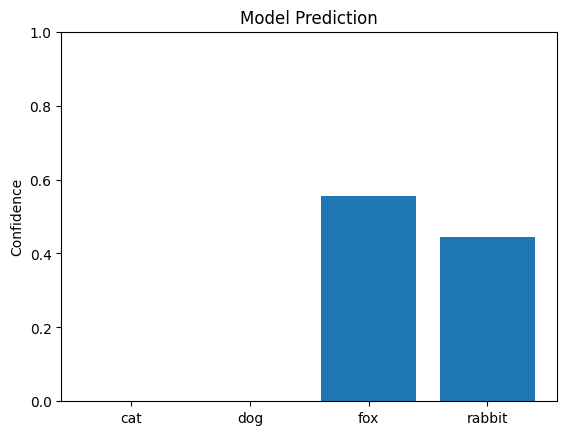

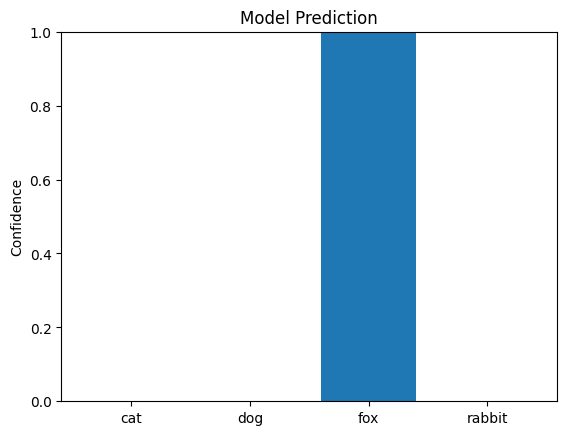

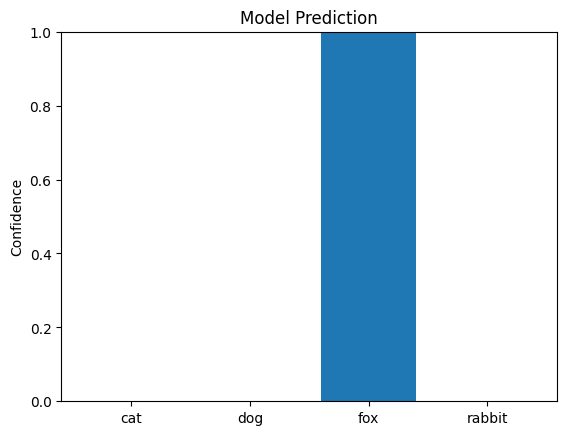

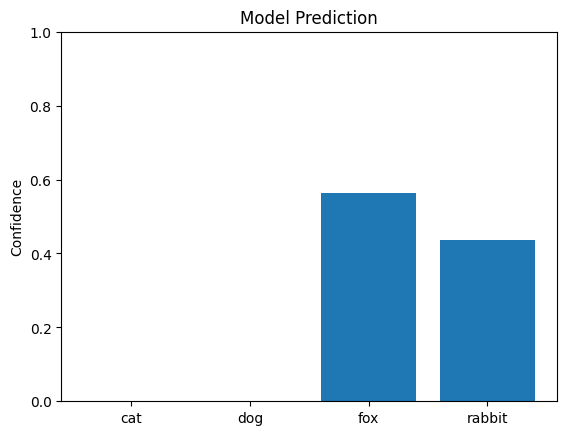

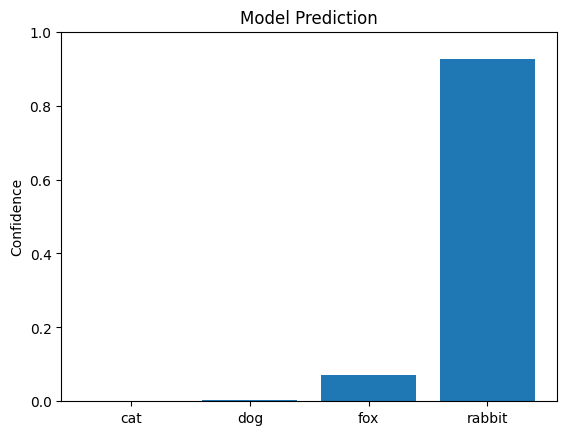

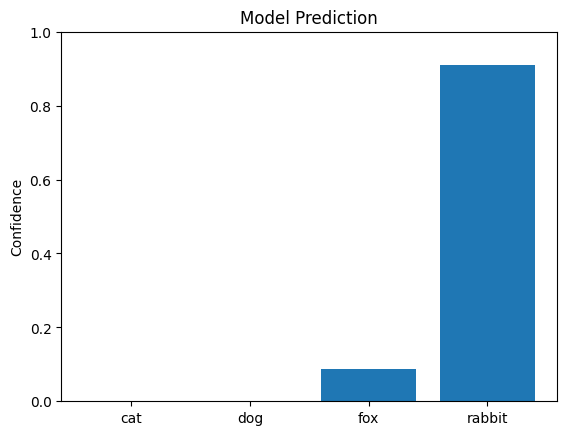

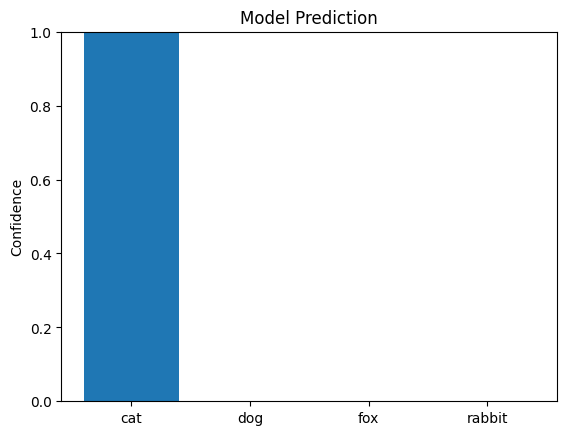

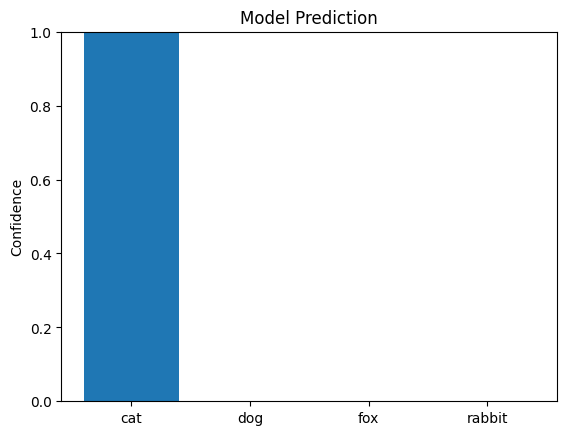

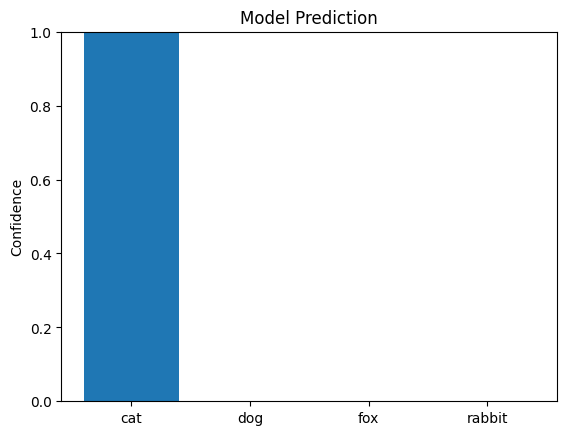

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class_names = ["cat", "dog", "fox", "rabbit"]

# 학습한 모델 구조와 동일해야 함!
class MultipleClassificationModel(nn.Module):
    def __init__(self, num_classes):
        """
        모델의 초기화 함수, 모델에 사용할 각 계층을 정의
        num_classes : 분류할 클래스의 수
        """
        super().__init__()
        
        #  첫 번째 Convolution Block
        # Conv2d :  이미지에서 특성을 추출하는 층
        # ( 입력 채널 : 3, 출력 채널 : 32, 커널 크기 : 3 x 3 )  / 커널(= 필터, 마스크) : 이미지로부터 원하는 특징만 추출하는 것
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # RGB 이미지 ( 채널 3 ) 을 입력받고, 32개의 특성 맵을 추출
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 개 특성 맵을 입력받고, 64개로 확장
        self.pool = nn.MaxPool2d(2, 2) # Max Pooling : 특성 맵의 크기를 절반으로 줄임 ( => 계산량 감소 )
        
        # 두 번째 Convolution Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64개의 특성 맵을 받아 128개로 확장
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 128개의 특성 맵을 받아 256개로 확장
        
        # Fully Connected Layers ( FC ) : 마지막에 나온 특성 맵을 1차원 벡터로 펼쳐서 분류 작업을 시행
        self.fc1 = nn.Linear(256 * 16 * 16, 1024) # 마지막 특성 맵을 1024개의 뉴런으로 변환
        self.fc2 = nn.Linear(1024, num_classes) # 1024개의 뉴런을 받아 최종 클래스 개수에 맞는 출력값을 생성'
    
    def forward(self, x):
        """
        입력 데이터 x를 모델을 통해 순차적으로 전달하며 예측을 생성
        """
        
        #  첫 번째 Convolution Block
        x = F.relu(self.conv1(x)) # 첫 번째 Conv2d + ReLU 활성화 함수
        x = self.pool(F.relu(self.conv2(x))) # 두 번째 Conv2d + ReLU + Max pooling
        
        x = F.relu(self.conv3(x)) # 세 번째 Conv2d + ReLU 활성화 함수
        x = self.pool(F.relu(self.conv4(x))) # 네 번째 Conv2d + ReLU + Max pooling
        
        # 전역 평균 풀링 (  Global Average Pooling ) : 특성 맵을 1차원 벡터로 평탄화
        x = x.view(-1, 256 * 16 * 16) # 특성 맵을 1차원 벡터로 펼침
        
        # Fully Connected Layers ( FC ) : 최종 분류 결과를 출력
        x = F.relu(self.fc1(x)) # 첫 번째 FC + ReLU 활성화 함수
        x = self.fc2(x) # 두 번째 FC : 최송 클래스에 대한 예측 결과
        return x

model = MultipleClassificationModel(num_classes=len(class_names))
model.load_state_dict(torch.load("./model/animal_face.pth"))
model.eval()

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

def show_prediction_bar(probabilities):
    plt.clf()
    plt.bar(class_names, probabilities)
    plt.ylim(0, 1)
    plt.ylabel("Confidence")
    plt.title("Model Prediction")
    plt.pause(0.01)
    
# 웹캠 실행
cap = cv2.VideoCapture(0)
plt.ion() # 그래프 실시간 업데이트

print("Print 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(img_rgb)
    input_tensor = transform(pil_image).unsqueeze(0)
    
    # 예측
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0].numpy()
        predicted_class = class_names[np.argmax(probabilities)]
    
    # 화면 출력
    text = f"Prediction: {predicted_class} ({100 * np.max(probabilities):.1f}%)"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.imshow("Webcam", frame)
    show_prediction_bar(probabilities)
    
    if cv2.waitKey(1) & 0xff == ord('q'):
        break

#  종료
cap.release()
cv2.destroyAllWindows()
plt.ioff()
plt.close()